In [1]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,export_questionnaire,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
                                      plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



In [2]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


## preapering the data

In [3]:


file_path = 'data/q_data/Study_Questionnaire_Responses_October.xlsx'
columns_to_select = ["Subject_Code", "b_questionnaire_completion", "after_questionnaire_completion", "t1_MAAS_date",
                         "t2_PHQ_date", "t3_MAAS_date"]

df = pd.read_excel(file_path)
columns = df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)

selected_df = df.loc[:, columns_to_select]

print("DataFrame with selected columns")
print(f"lines: {selected_df .shape[0]}, columns: {selected_df .shape[1]}")


print("\nהצגת ה-DataFrame החדש (5 השורות הראשונות):")
print(selected_df.head())


the columns in the dataframe:
study_id
Subject_Code
diamond_interview_date
b_diamond_anxiety_phobias_past
b_diamond_Anxiety_phobias_present
b_diamond_ocd_past
b_diamond_ocd_present
b_diamond_adhd_past
b_diamond_adhd_present
b_diamond_depression_past
b_diamond_depression_present
b_diamond_adjustment_past
b_diamond_adjustment_present
b_diamond_ptsd_past
b_diamond_ptsd_present
b_diamond_eating_disorder_past
b_diamond_eating_disorder_present
b_diamond_PMS_past
b_diamond_PMS_present
b_diamond_other_past
b_diamond_other_present
b_diamond_past
b_diamond_present
Dropped_Out_of_Study
Became_Pregnant
Gave_Birth
Dominant_hand
Completed_First_fMRI
Completed_Second_fMRI
Completed_Third_fMRI
b_questionnaire_completion
after_questionnaire_completion
first_fmri_scan_date
second_fmri_scan_date
third_fmri_scan_date
b_questionnaire_and_fmri_days_difference
pregnancy_start_date
b_fmri_and_pregnancy_days_difference
newborn_birth_date
Days_from_Birth_to_Questionnaire_Completion
Demographics_Date
date_of_bir

In [4]:
# see the columns in the dataframe
columns = selected_df.columns.tolist()
print("the columns in the dataframe:")
for col in columns:
    print(col)
phq_columns = ['b_PHQ_1','b_PHQ_2','b_PHQ_3','b_PHQ_4','b_PHQ_5','b_PHQ_6','b_PHQ_7','b_PHQ_8','b_PHQ_9'
                                                                                               ,'b_PHQ_10',
't1_PHQ_1','t1_PHQ_2','t1_PHQ_3','t1_PHQ_4','t1_PHQ_5','t1_PHQ_6','t1_PHQ_7','t1_PHQ_8','t1_PHQ_9','t1_PHQ_10',
               't2_PHQ_1','t2_PHQ_2','t2_PHQ_3','t2_PHQ_4','t2_PHQ_5','t2_PHQ_6','t2_PHQ_7','t2_PHQ_8','t2_PHQ_9','t2_PHQ_10',
               't3_PHQ_1','t3_PHQ_2','t3_PHQ_3','t3_PHQ_4','t3_PHQ_5','t3_PHQ_6','t3_PHQ_7','t3_PHQ_8','t3_PHQ_9','t3_PHQ_10',
               'after_PHQ_1','after_PHQ_2','after_PHQ_3','after_PHQ_4','after_PHQ_5','after_PHQ_6','after_PHQ_7','after_PHQ_8','after_PHQ_9','after_PHQ_10']
gad_columns = ['b_GAD7_1','b_GAD7_2','b_GAD7_3','b_GAD7_4','b_GAD7_5','b_GAD7_6','b_GAD7_7',
               't1_GAD7_1','t1_GAD7_2','t1_GAD7_3','t1_GAD7_4','t1_GAD7_5','t1_GAD7_6','t1_GAD7_7',
               't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7',
               't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
               'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']




the columns in the dataframe:
Subject_Code
b_questionnaire_completion
after_questionnaire_completion
t1_MAAS_date
t2_PHQ_date
t3_MAAS_date


In [5]:
df_cleaned = df[['Subject_Code','Dropped_Out_of_Study']+phq_columns+gad_columns]
print(df_cleaned.columns.tolist())

# Remove the subjects who were dropped out of the study
df_filtered = df_cleaned[df_cleaned['Dropped_Out_of_Study'] != 1]

# calculating the number of nan in each column
counts = df_filtered.notna().sum()

# Calculating the percentage of respondents who answered the specific questionnaire out of all respondents
total = len(df_filtered)
percentages = (counts / total * 100)

# creating a new table of number of students and the precentages of the subjects
summary_df = pd.DataFrame([counts, percentages], index=['number of subject', '% of subjects'])


# שמירת הטבלה כקובץ Excel
summary_df.to_excel("data/q_data/combined/summary_table.xlsx")


['Subject_Code', 'Dropped_Out_of_Study', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_PHQ_10', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_PHQ_10', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_PHQ_10', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_PHQ_10', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_PHQ_10', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3

In [6]:
# הרצה עבור כל סט
export_questionnaire(df_cleaned, 'b', 'data/q_data/5_timepoints/b_questionnaire')
export_questionnaire(df_cleaned, 't1', 'data/q_data/5_timepoints/t1_questionnaire')
export_questionnaire(df_cleaned, 't2', 'data/q_data/5_timepoints/t2_questionnaire')
export_questionnaire(df_cleaned, 't3', 'data/q_data/5_timepoints/t3_questionnaire')
export_questionnaire(df_cleaned, 'after', 'data/q_data/5_timepoints/after_questionnaire')


✅ נוצר הקובץ: data/q_data/5_timepoints/b_questionnaire.csv
📌 מספר נבדקות בקובץ: 141
📋 עמודות שנכללו:
b_PHQ_1, b_PHQ_2, b_PHQ_3, b_PHQ_4, b_PHQ_5, b_PHQ_6, b_PHQ_7, b_PHQ_8, b_PHQ_9, b_PHQ_10, b_GAD7_1, b_GAD7_2, b_GAD7_3, b_GAD7_4, b_GAD7_5, b_GAD7_6, b_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t1_questionnaire.csv
📌 מספר נבדקות בקובץ: 139
📋 עמודות שנכללו:
t1_PHQ_1, t1_PHQ_2, t1_PHQ_3, t1_PHQ_4, t1_PHQ_5, t1_PHQ_6, t1_PHQ_7, t1_PHQ_8, t1_PHQ_9, t1_PHQ_10, t1_GAD7_1, t1_GAD7_2, t1_GAD7_3, t1_GAD7_4, t1_GAD7_5, t1_GAD7_6, t1_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t2_questionnaire.csv
📌 מספר נבדקות בקובץ: 132
📋 עמודות שנכללו:
t2_PHQ_1, t2_PHQ_2, t2_PHQ_3, t2_PHQ_4, t2_PHQ_5, t2_PHQ_6, t2_PHQ_7, t2_PHQ_8, t2_PHQ_9, t2_PHQ_10, t2_GAD7_1, t2_GAD7_2, t2_GAD7_3, t2_GAD7_4, t2_GAD7_5, t2_GAD7_6, t2_GAD7_7

✅ נוצר הקובץ: data/q_data/5_timepoints/t3_questionnaire.csv
📌 מספר נבדקות בקובץ: 121
📋 עמודות שנכללו:
t3_PHQ_1, t3_PHQ_2, t3_PHQ_3, t3_PHQ_4, t3_PHQ_5, t3_PHQ_6, t3_PHQ_7, t3_PH

In [7]:
q_before = 'data/q_data/5_timepoints/b_questionnaire.csv'
q_t1  = 'data/q_data/5_timepoints/t1_questionnaire.csv'
q_t2 = 'data/q_data/5_timepoints/t2_questionnaire.csv'
q_t3 = 'data/q_data/5_timepoints/t3_questionnaire.csv'
q_after = 'data/q_data/5_timepoints/after_questionnaire.csv'

analyze_questionnaire('b',q_before)
analyze_questionnaire( 't1', q_t1)
analyze_questionnaire( 't2', q_t2)
analyze_questionnaire('t3', q_t3)
analyze_questionnaire( 'after', q_after)



📘 קובץ: data/q_data/5_timepoints/b_questionnaire.csv
👥 נבדקות פעילות: 141
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t1_questionnaire.csv
👥 נבדקות פעילות: 139
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t2_questionnaire.csv
👥 נבדקות פעילות: 132
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/t3_questionnaire.csv
👥 נבדקות פעילות: 121
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)

📘 קובץ: data/q_data/5_timepoints/after_questionnaire.csv
👥 נבדקות פעילות: 125
   🔸 PHQ: ממוצע השתתפות 100.00% (10 שאלות)
   🔸 GAD7: ממוצע השתתפות 100.00% (7 שאלות)


In [8]:
df_before = pd.read_csv('data/q_data/5_timepoints/b_questionnaire.csv')
prefix = "b"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_before.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_before.columns]
df_before['timepoint'] = prefix
print(df_before.columns)

df_t1 = pd.read_csv('data/q_data/5_timepoints/t1_questionnaire.csv')
prefix = "t1"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t1['timepoint'] = prefix
df_t1.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t1.columns]
print(df_t1.columns)

df_t2 = pd.read_csv('data/q_data/5_timepoints/t2_questionnaire.csv')
prefix = "t2"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t2['timepoint'] = prefix
df_t2.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t2.columns]
print(df_t2.columns)

df_t3 = pd.read_csv('data/q_data/5_timepoints/t3_questionnaire.csv')
prefix = "t3"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_t3['timepoint'] = prefix
df_t3.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_t3.columns]
print(df_t3.columns)

df_after = pd.read_csv('data/q_data/5_timepoints/after_questionnaire.csv')
prefix = "after"
# נסיר את התחילית משמות כל העמודות שמתחילות בה
df_after['timepoint'] = prefix
df_after.columns = [col[len(prefix)+1:] if col.startswith(prefix) else col for col in df_after.columns]
print(df_after.columns)



Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
      dtype='object')
Index(['Unnamed: 0', 'Subject_Code', 'PHQ_1', 'PHQ_2', 'PHQ_3', 'PHQ_4',
       'PHQ_5', 'PHQ_6', 'PHQ_7', 'PHQ_8', 'PHQ_9', 'PHQ_10', 'GAD7_1',
       'GAD7_2', 'GAD7_3', 'GAD7_4', 'GAD7_5', 'GAD7_6', 'GAD7_7',
       'timepoint'],
  

In [9]:



# 1. יצירת רשימה של כל הדאטה-פריימים
list_of_dfs = [df_before, df_t1, df_t2,df_t3,df_after]

# 2. שימוש ב-pd.concat לשרשור הרשימה
# אנחנו משתמשים ב-ignore_index=True כדי שהאינדקס של התוצאה יהיה רציף (...0, 1, 2, 3)
# אם לא נשתמש בזה, נקבל אינדקסים שחוזרים על עצמם (למשל ...0, 1, 0, 1, 0, 1)
df_combined = pd.concat(list_of_dfs, ignore_index=True)

print("\n--- DataFrame מאוחד ---")
df_combined = df_combined.drop(columns = 'Unnamed: 0')
print(df_combined)
df_combined.to_csv('data/q_data/combined/combined.csv')


--- DataFrame מאוחד ---
    Subject_Code  PHQ_1  PHQ_2  PHQ_3  PHQ_4  PHQ_5  PHQ_6  PHQ_7  PHQ_8  \
0          CT002    0.0    0.0    1.0    1.0    1.0    0.0    1.0    1.0   
1          CT003    0.0    1.0    1.0    2.0    0.0    0.0    0.0    0.0   
2          CT004    0.0    0.0    1.0    1.0    0.0    1.0    1.0    0.0   
3          CT005    0.0    1.0    3.0    3.0    2.0    0.0    2.0    0.0   
4          CT007    1.0    1.0    0.0    1.0    0.0    1.0    0.0    0.0   
..           ...    ...    ...    ...    ...    ...    ...    ...    ...   
653        NT123    0.0    0.0    2.0    2.0    0.0    0.0    1.0    0.0   
654        NT124    0.0    0.0    3.0    3.0    0.0    0.0    1.0    0.0   
655        NT126    0.0    1.0    1.0    2.0    0.0    0.0    1.0    0.0   
656        NT129    2.0    3.0    3.0    2.0    3.0    2.0    2.0    1.0   
657        NT136    1.0    1.0    0.0    1.0    1.0    2.0    2.0    0.0   

     PHQ_9  PHQ_10  GAD7_1  GAD7_2  GAD7_3  GAD7_4  GAD7_5  GA

In [10]:
## pca on the combined data


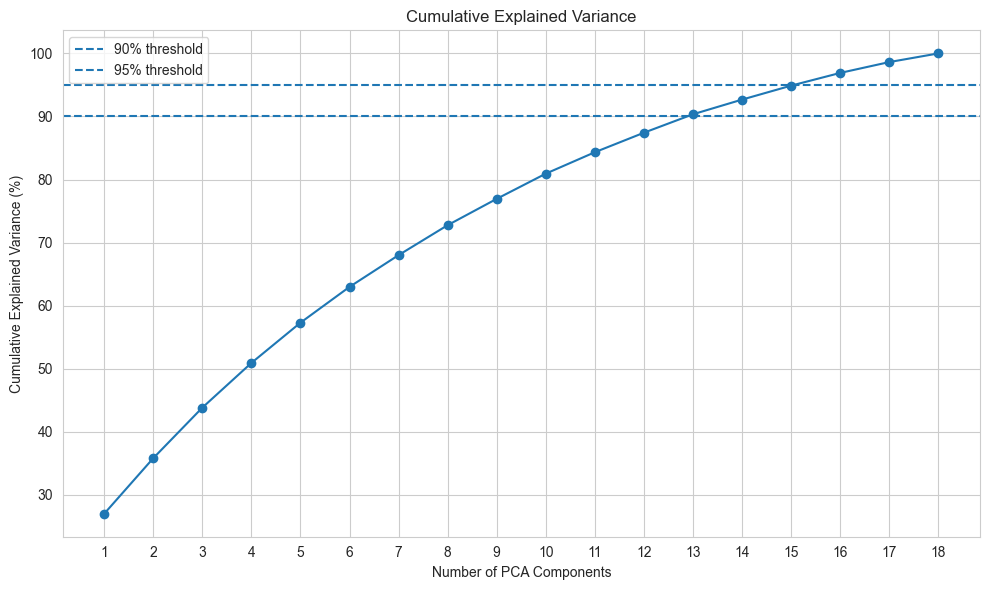

✅ 90% variance: 13 components
✅ 95% variance: 16 components
✅ 100% variance: 18 components
🖼️ Saved figure: data/only_Q_outputs/combined/ses1_figures\b_questionnaire_pca_cumulative_variance.png

Recommended number of dimensions for 90%: 13


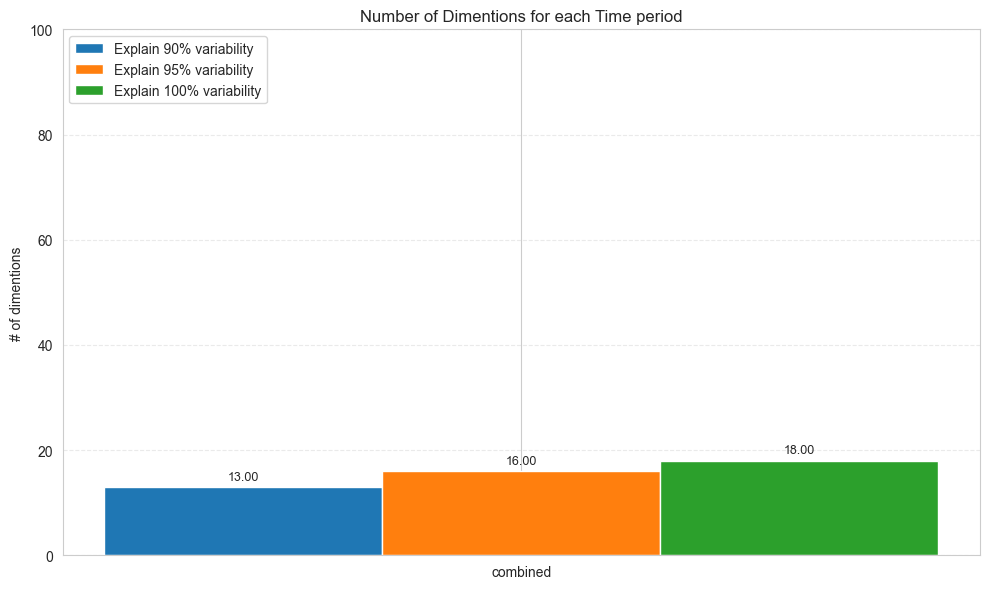

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Number of Dimentions for each Time period'}, ylabel='# of dimentions'>)

In [11]:
n_dims_comb_90, n_dims_comb_95, n_dims_comb_100 = find_optimal_pca_dimensions(q_before,save_dir="data/only_Q_outputs/combined/ses1_figures")
print(f"\nRecommended number of dimensions for 90%: {n_dims_comb_90}")
groups = ["combined"]
s1 = [n_dims_comb_90]  # values for column 1 in each
s2 = [n_dims_comb_95]  # values for column 2
s3 = [n_dims_comb_100]  # values for column 2

plot_grouped_bars(groups, s1, s2, s3,
                  s1_label="Explain 90% variability",
                  s2_label="Explain 95% variability",
                  s3_label="Explain 100% variability",
                  title="Number of Dimentions for each Time period",
                  ylabel="# of dimentions")



## searc for optimal clusters number


Prefix is empty, selecting 'PHQ_' and 'GAD7_' columns explicitly.
[[-0.75333605 -0.9167544  -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [-0.75333605  0.56173677 -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [-0.75333605 -0.9167544  -0.13033363 ... -0.34070929 -0.84224674
  -0.65256975]
 ...
 [-0.75333605  0.56173677 -0.13033363 ... -0.34070929  0.47727315
  -0.65256975]
 [ 2.00819665  3.51871911  1.91155992 ... -0.34070929  0.47727315
   2.31899353]
 [ 0.6274303   0.56173677 -1.15128041 ... -0.34070929 -0.84224674
   0.83321189]]

✅ נתוני PCA נשמרו בהצלחה ב: data/only_Q_outputs/combined/combined_pca_components.csv


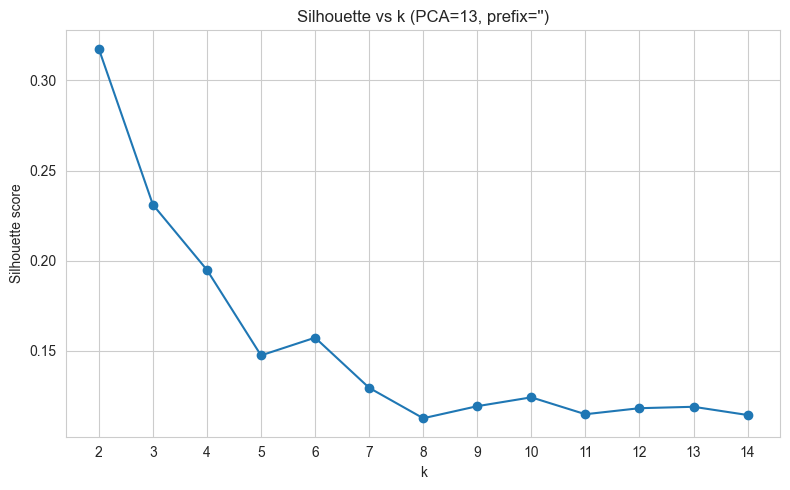


✅ מספר הקלאסטרים שנבחר לפי סילואט: 2
    subject_id  cluster  silhouette_sample
0        CT002        1           0.426507
1        CT003        1           0.345538
2        CT004        1           0.486278
3        CT005        1           0.177001
4        CT007        0          -0.056200
..         ...      ...                ...
653      NT123        1           0.485627
654      NT124        1           0.374563
655      NT126        1           0.465284
656      NT129        0           0.237946
657      NT136        0          -0.037150

[658 rows x 3 columns]


In [12]:
# השתמש בפונקציה המתוקנת שהגדרנו למעלה
res_comb = pca_kmeans_minimal_outputs(
    df_combined,
    prefix="",  # עכשיו הפונקציה יודעת לטפל בזה
    n_components=n_dims_comb_90,
    k_range=range(2, 15),
    top_k_features=20,
    save_dir="data/only_Q_outputs/combined",
    subject_id_col='Subject_Code', # <--- הוסף את השורה הזו
    save_pca_csv = 'data/only_Q_outputs/combined/combined_pca_components.csv'
)

In [13]:
sil_scores_comb = res_comb["sil_scores"]
print("k* =", res_comb["best_k"])


ks = list(range(2, 15))  # same k_range you used in the runs

sil_comb = res_comb["sil_scores"].iloc[:, 0].values


best_k_comb_sil = res_comb["best_k"]

k* = 2


## mark timeperiods on the pca data

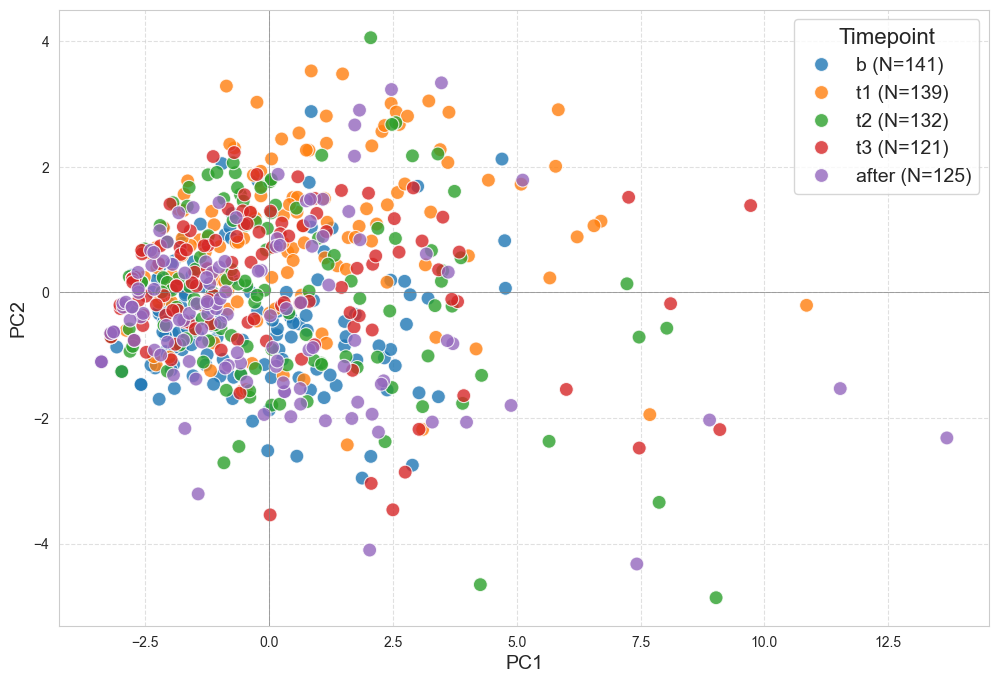

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA שיצרנו
pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"

# 2. טעינת הנתונים
pca_df = None
try:
    pca_df = pd.read_csv(pca_file_path)
except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
    print("אנא ודא שהרצת את השלב הקודם ששומר את קובץ ה-PCA.")
    # raise

# 3. הכנה לתוספות הסטטיסטיות (נדרש רק אם ה-DataFrame נטען)
if pca_df is not None:
    # --- חישוב מספר נקודות הנתונים הכולל ---
    total_datapoints = len(pca_df)

    # --- חישוב גודל כל קבוצה (timepoint) לצורך עדכון המקרא ---
    group_counts = pca_df['timepoint'].value_counts().sort_index()

    # --- יצירת עמודת מקרא חדשה המשלבת את שם הקבוצה ואת גודלה ---
    # נשתמש במילון כדי למפות את שם ה-timepoint המקורי לתווית החדשה
    legend_map = {
        tp: f"{tp} (N={count})"
        for tp, count in group_counts.items()
    }

    # יצירת העמודה החדשה שבה נשתמש ל-hue
    pca_df['Legend_Label'] = pca_df['timepoint'].map(legend_map)

    # 4. יצירת הגרף עם Seaborn
    plt.figure(figsize=(12, 8)) # קביעת גודל הגרף

    sns.scatterplot(
        data=pca_df,
        x='PC1',              # רכיב עיקרי 1 על ציר X
        y='PC2',              # רכיב עיקרי 2 על ציר Y
        hue='Legend_Label',   # שימוש בתווית החדשה המכילה את גודל הקבוצה
        s=100,                # גודל הנקודות
        alpha=0.8             # שקיפות הנקודות
    )

    # 5. הוספת כותרות ושיפורים
    # --- הוספת מספר נקודות הנתונים לכותרת ---
    plt.xlabel(f'PC1',fontsize = 14)
    plt.ylabel(f'PC2',fontsize = 14)
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- עדכון כותרת המקרא ---
    plt.legend(title='Timepoint', fontsize=14, title_fontsize=16)

    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    # 6. הצגת הגרף
    plt.show()

## mark subjects trajectory on the pca data

נמצאו 79 נבדקים המופיעים 5 פעמים. הם יודגשו בצבע.

הגרף נשמר בהצלחה ב: data/only_Q_outputs/combined/pca_plot_by_subject_5_times.png


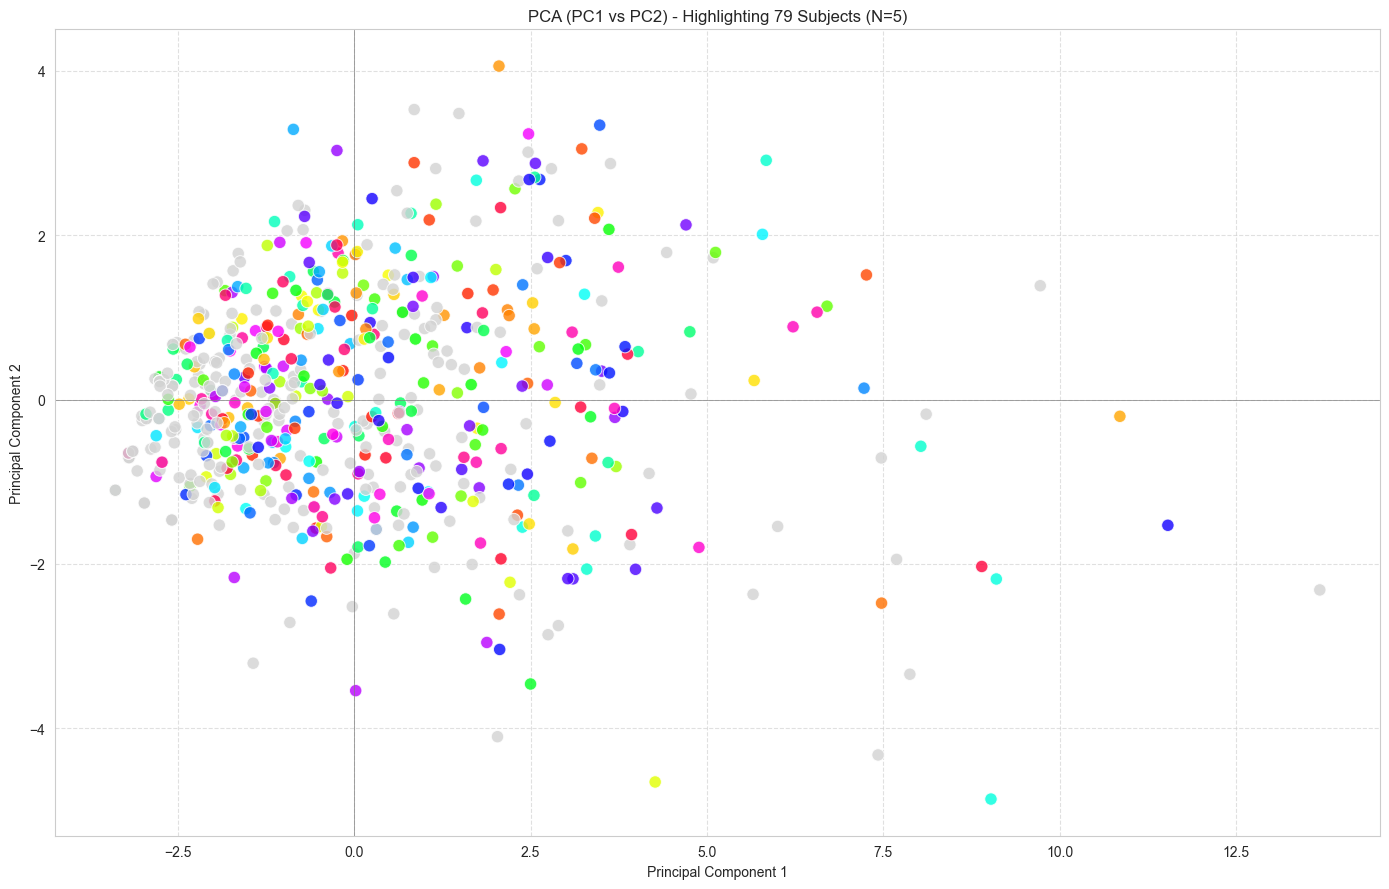

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA
pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
save_path = "data/only_Q_outputs/combined/pca_plot_by_subject_5_times.png"

try:
    # 2. טעינת הנתונים
    pca_df = pd.read_csv(pca_file_path)

    # 3. זיהוי הנבדקים שמופיעים 5 פעמים
    # ספירת מופעים לכל נבדק
    subject_counts = pca_df['Subject_Code'].value_counts()

    # יצירת רשימה של שמות הנבדקים שמופיעים בדיוק 5 פעמים
    subjects_to_highlight = subject_counts[subject_counts == 5].index.tolist()

    if not subjects_to_highlight:
        print("לא נמצאו נבדקים המופיעים בדיוק 5 פעמים.")
    else:
        print(f"נמצאו {len(subjects_to_highlight)} נבדקים המופיעים 5 פעמים. הם יודגשו בצבע.")

    # 4. יצירת עמודת צביעה חדשה
    # ניצור עמודה ששומרת את שם הנבדק (אם הוא ברשימה) או 'Other' (אם לא)

    other_label = 'Other (N != 5)'

    def get_color_group(subject_code):
        if subject_code in subjects_to_highlight:
            return subject_code  # השאר את שם הנבדק
        else:
            return other_label # סמן כ"אחר"

    # החלת הפונקציה ליצירת העמודה החדשה
    pca_df['color_group'] = pca_df['Subject_Code'].apply(get_color_group)

    # 5. יצירת פלטת צבעים מותאמת
    # אנחנו רוצים שהקבוצה 'Other' תהיה אפורה, והשאר יהיו צבעוניים

    unique_groups = pca_df['color_group'].unique().tolist()
    palette_dict = {}

    # חישוב מספר הצבעים שנצטרך
    num_highlighted = len(unique_groups) - (1 if other_label in unique_groups else 0)

    if num_highlighted > 0:
        # שימוש בפלטת צבעים מגוונת (hsv) כי יש 79 נבדקים
        colors = sns.color_palette('hsv', n_colors=num_highlighted)
    else:
        colors = []

    color_idx = 0
    for group in unique_groups:
        if group == other_label:
            palette_dict[group] = 'lightgrey' # צבע אפור בהיר לרקע
        else:
            palette_dict[group] = colors[color_idx]
            color_idx += 1

    # 6. יצירת הגרף
    plt.figure(figsize=(14, 9))

    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='color_group',    # צביעה לפי הקבוצה החדשה שיצרנו
        palette=palette_dict, # שימוש בפלטת הצבעים המותאמת
        s=80,
        alpha=0.8,
        legend=False          # <-- החלטנו לא להציג את המקרא כי 79 שמות זה יותר מדי
    )

    # 7. הוספת כותרות ושיפורים
    plt.title(f'PCA (PC1 vs PC2) - Highlighting {len(subjects_to_highlight)} Subjects (N=5)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    plt.tight_layout() # התאמה אוטומטית של הגבולות

    # 8. שמירת הגרף
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
except Exception as e:
    print(f"אירעה שגיאה: {e}")

In [16]:
import pandas as pd

pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"

try:
    pca_df = pd.read_csv(pca_file_path)

    # זיהוי הנבדקים שמופיעים 5 פעמים
    subject_counts = pca_df['Subject_Code'].value_counts()
    subjects_with_5 = subject_counts[subject_counts == 5].index.tolist()

    print(f"--- רשימת {len(subjects_with_5)} הנבדקים לבחירה (מופיעים 5 פעמים) ---")
    # הדפסת הרשימה בפורמט שקל להעתיק
    print(subjects_with_5)

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")

--- רשימת 79 הנבדקים לבחירה (מופיעים 5 פעמים) ---
['CT003', 'CT004', 'CT005', 'CT007', 'CT010', 'CT008', 'CT012', 'CT013', 'CT051', 'CT015', 'CT022', 'CT027', 'CT026', 'CT025', 'CT024', 'CT023', 'CT029', 'CT028', 'CT050', 'CT039', 'CT038', 'CT034', 'CT033', 'CT031', 'CT044', 'CT046', 'CT041', 'NT018', 'NT023', 'NT022', 'NT025', 'NT024', 'NT033', 'NT005', 'NT010', 'NT007', 'NT002', 'NT001', 'CT061', 'CT058', 'NT082', 'NT069', 'NT060', 'NT058', 'NT063', 'NT065', 'NT123', 'NT126', 'NT094', 'NT096', 'NT097', 'NT100', 'NT090', 'NT017', 'NT016', 'NT015', 'NT034', 'NT030', 'NT027', 'NT028', 'NT077', 'NT081', 'NT074', 'NT055', 'NT047', 'NT048', 'NT049', 'NT046', 'NT042', 'NT040', 'NT039', 'NT036', 'NT129', 'NT136', 'NT118', 'NT124', 'NT089', 'NT091', 'NT085']


הנבדקים שנבחרו ידנית להדגשה: ['CT003', 'CT039', 'CT058', 'NT046', 'NT061', 'NT085', 'NT018', 'CT050', 'CT100', 'CT004']

הגרף נשמר בהצלחה ב: data/only_Q_outputs/combined/pca_plot_10_manual_subjects.png


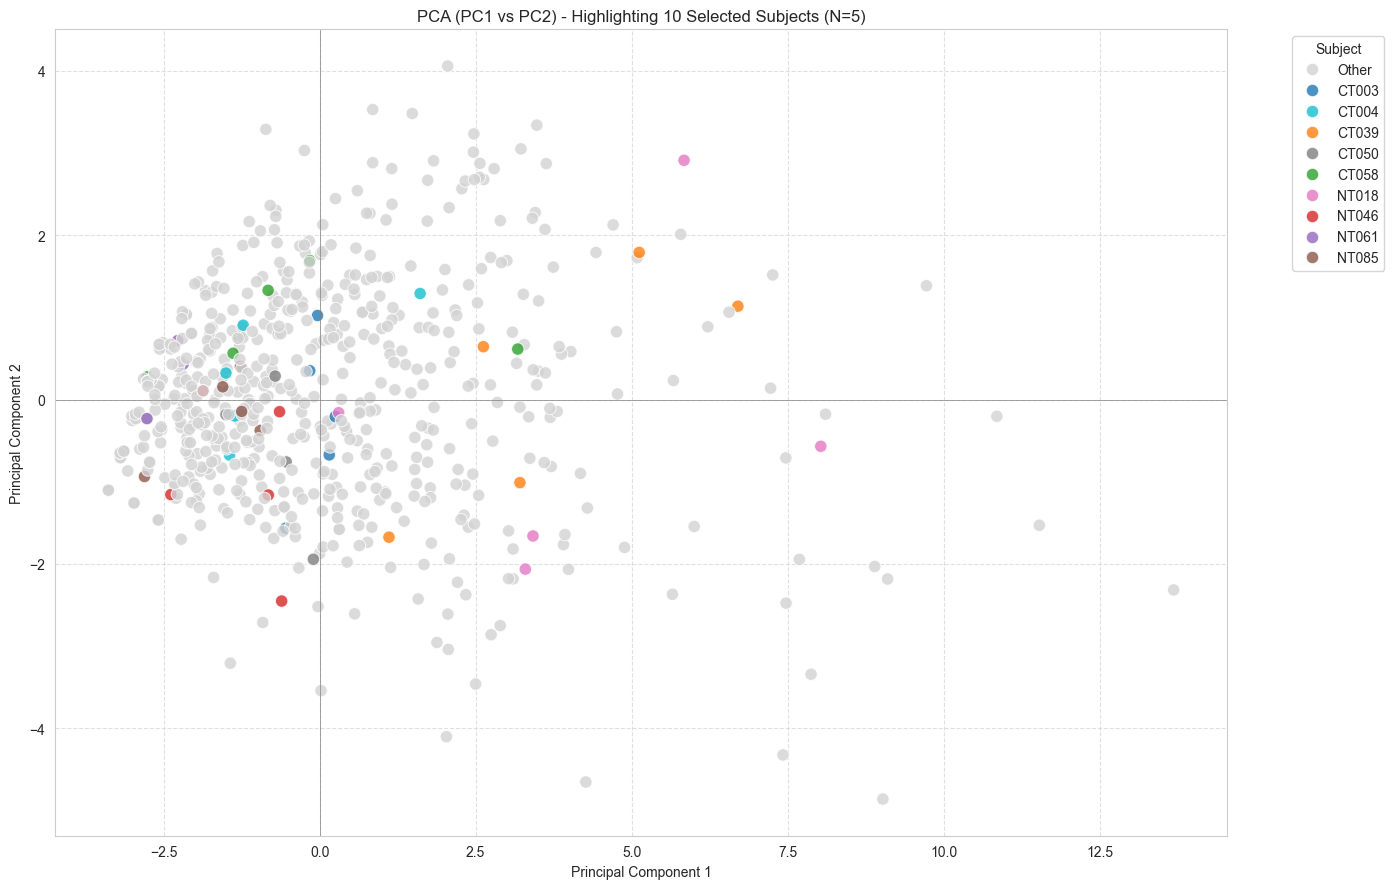

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. הגדרת הנתיב לקובץ ה-PCA
pca_file_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
save_path = "data/only_Q_outputs/combined/pca_plot_10_manual_subjects.png"

try:
    # 2. טעינת הנתונים
    pca_df = pd.read_csv(pca_file_path)

    # ==========================================================
    #               👇 כאן להדביק את הבחירה שלך 👇
    # ==========================================================

    # 💡 הוראות:
    # העתק 10 שמות מהרשימה שהודפסה בשלב 1
    # והדבק אותם כאן. למשל:
    # ['NT085', 'NT015', 'CT061', 'NT002', 'NT030', 'NT126', 'NT039', 'CT029', 'CT008', 'CT013']

    subjects_to_highlight = [
        # הדבק כאן 10 שמות, כל אחד במרכאות ומופרד בפסיק
        'CT003', 'CT039', 'CT058', 'NT046', 'NT061',
        'NT085', 'NT018', 'CT050', 'CT100', 'CT004'
    ]

    # ==========================================================
    #               👆 סוף אזור הבחירה 👆
    # ==========================================================

    print(f"הנבדקים שנבחרו ידנית להדגשה: {subjects_to_highlight}")

    # 5. יצירת עמודת צביעה חדשה
    other_label = 'Other'

    def get_color_group(subject_code):
        if subject_code in subjects_to_highlight:
            return subject_code  # השאר את שם הנבדק
        else:
            return other_label # סמן כ"אחר"

    pca_df['color_group'] = pca_df['Subject_Code'].apply(get_color_group)

    # 6. יצירת פלטת צבעים מותאמת (10 צבעים + אפור)
    palette_dict = {}
    colors = sns.color_palette("tab10", n_colors=10)

    for i, subject in enumerate(subjects_to_highlight):
        palette_dict[subject] = colors[i]

    palette_dict[other_label] = 'lightgrey'

    # 7. יצירת הגרף
    plt.figure(figsize=(14, 9))

    sns.scatterplot(
        data=pca_df,
        x='PC1',
        y='PC2',
        hue='color_group',    # צביעה לפי הקבוצה החדשה
        palette=palette_dict, # שימוש בפלטת הצבעים המותאמת
        s=80,
        alpha=0.8,
        legend='full'         # הפעם נציג את המקרא
    )

    # 8. הוספת כותרות ושיפורים
    plt.title(f'PCA (PC1 vs PC2) - Highlighting 10 Selected Subjects (N=5)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5)
    plt.axvline(0, color='grey', linewidth=0.5)

    plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # 9. שמירת הגרף
    plt.savefig(save_path, dpi=150)
    print(f"\nהגרף נשמר בהצלחה ב: {save_path}")

except FileNotFoundError:
    print(f"הקובץ לא נמצא בנתיב: {pca_file_path}")
except Exception as e:
    print(f"אירעה שגיאה: {e}")

## k means on the combined pca  dataset


Cluster assignments saved to data/only_Q_outputs/combined/clusters_combined.csv


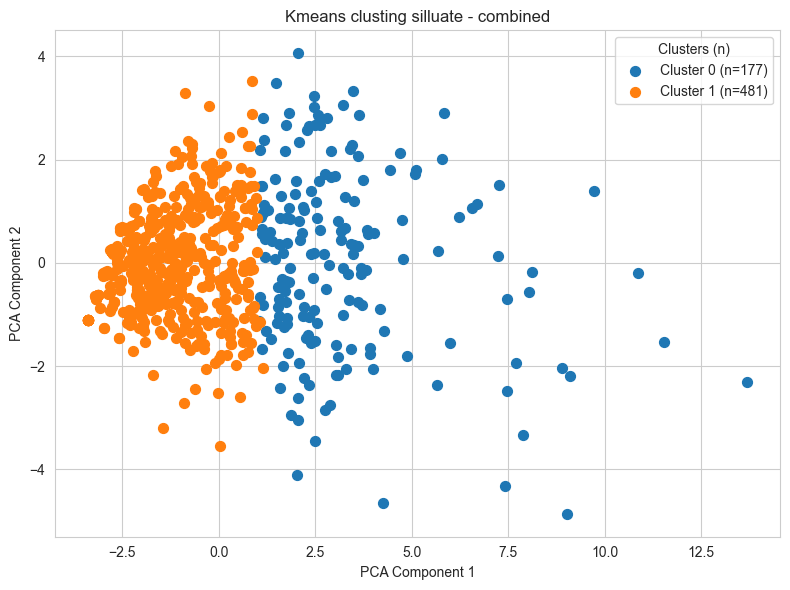

אירעה שגיאה: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


In [18]:

labels_comb_sil, data_pca_comb_sil, model_comb_sil, pca_comb_sil = run_kmeans_clustering(
    df=df_combined,
    prefix="",  # your prefix
    n_components=n_dims_comb_90,
    k=best_k_comb_sil,  # from your gap statistic
    plot=True,
    title="Kmeans clusting silluate - combined",
    csv_path="data/only_Q_outputs/combined/clusters_combined.csv",  include_timepoints=True)



# 1. הגדרת נתיבי הקבצים
pca_data_path = "data/only_Q_outputs/combined/combined_pca_components.csv"
cluster_data_path = "data/only_Q_outputs/combined/clusters_combined.csv"

# נתיב שמירה חדש לטבלת הסיכום
summary_save_path = "data/only_Q_outputs/combined_no_pca/cluster_timepoint_summary.csv"

try:
    # 2. טעינת שני קבצי התוצאות
    pca_df = data_pca_comb_sil
    cluster_df = pd.read_csv(cluster_data_path)

    # 3. מיזוג הקבצים
    merged_df = pd.merge(
        pca_df[['Subject_Code', 'timepoint', 'PC1', 'PC2']],
        cluster_df[['Subject_Code', 'timepoint', 'cluster']],
        on=['Subject_Code', 'timepoint']
    )

    # ==========================================================
    #         👇 הוספת הקוד לסיכום הנתונים 👇
    # ==========================================================

    # 4. יצירת טבלת הסיכום (crosstab)
    #    האשכולות יהיו השורות, ונקודות הזמן יהיו העמודות
    summary_table = pd.crosstab(
        index=merged_df['cluster'],     # השורות
        columns=merged_df['timepoint'], # העמודות
        margins=True,                   # הוסף שורת ועמודת "סך הכל"
        margins_name="Total"            # קרא לסך הכל "Total"
    )

    # 5. הדפסת הטבלה למסך
    print("--- סיכום נבדקים: אשכול מול נקודת זמן ---")
    print(summary_table)

    # 6. שמירת הטבלה לקובץ CSV
    summary_table.to_csv(summary_save_path)
    print(f"\nטבלת הסיכום נשמרה ב: {summary_save_path}")

    # ==========================================================
    #                  👆 סוף הקוד לסיכום 👆
    # ==========================================================

    # (הקוד הקודם לשרטוט הגרף יכול להמשיך מכאן אם תרצה)

except FileNotFoundError as e:
    print(f"שגיאה: הקובץ לא נמצא. אנא ודא ששני הקבצים קיימים בנתיבים הנכונים.")
    print(e)
except Exception as e:
    print(f"אירעה שגיאה: {e}")

## k meand per timepoint on the pca combined dataset


--- Running clustering for EACH timepoint ---

================ Running for timepoint: b ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_b.csv


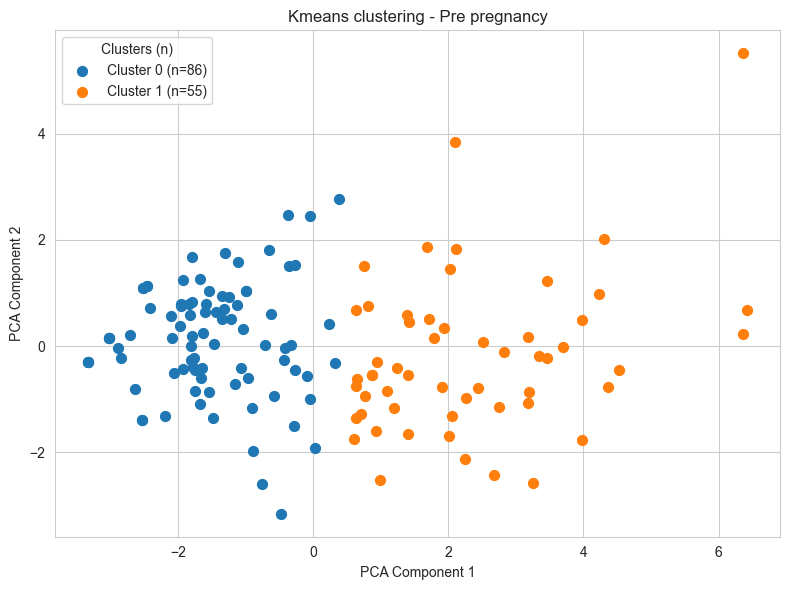


================ Running for timepoint: t1 ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t1.csv


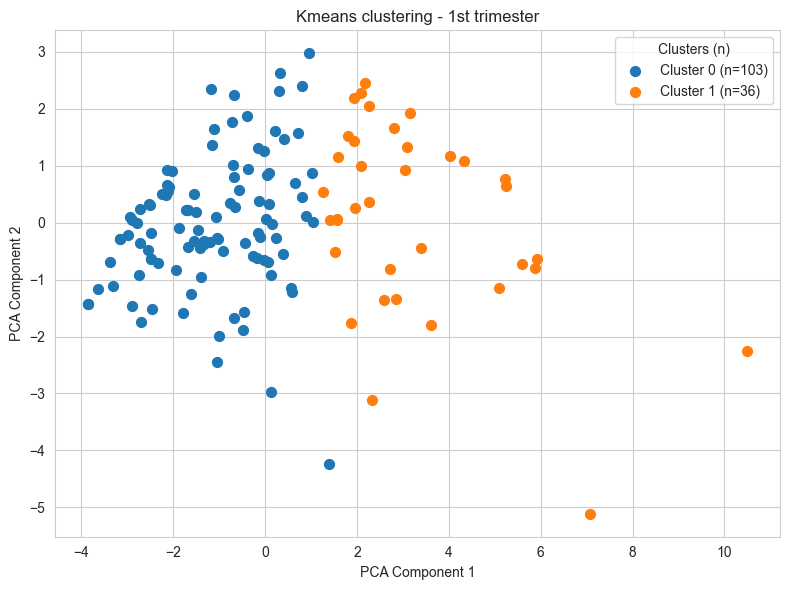


================ Running for timepoint: t2 ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t2.csv


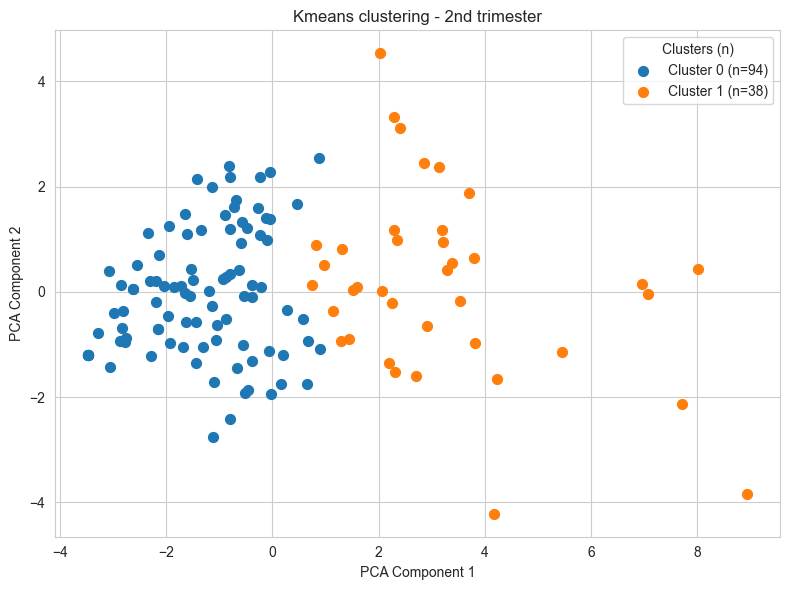


================ Running for timepoint: t3 ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_t3.csv


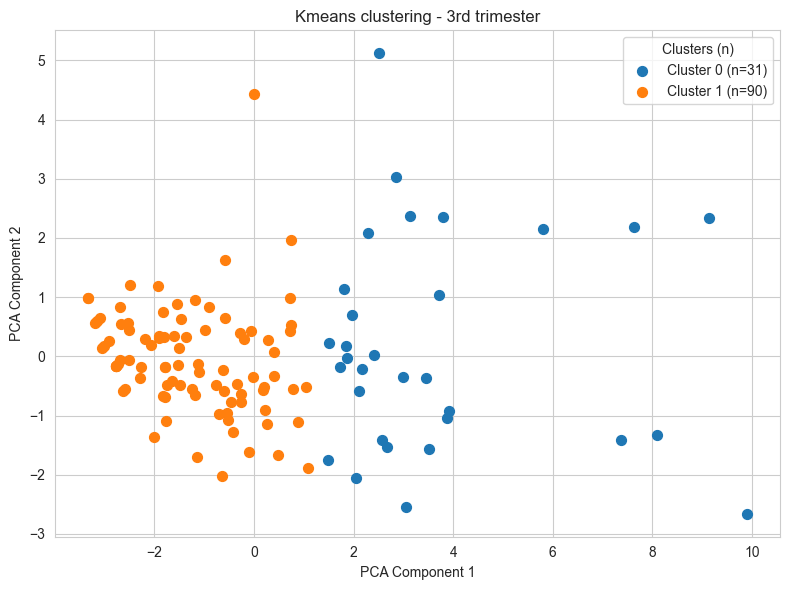


================ Running for timepoint: after ================
Cluster assignments saved to data/only_Q_outputs/combined/clusters_after.csv


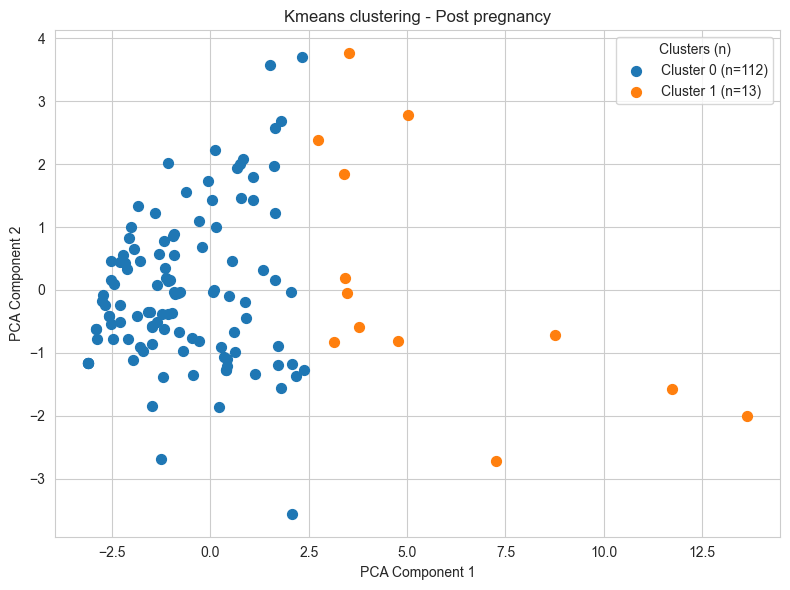


✅ All timepoints processed.
--- Generating final 2x3 combined plot ---


C:\Users\nogag\AppData\Local\Temp\ipykernel_27500\4105670899.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


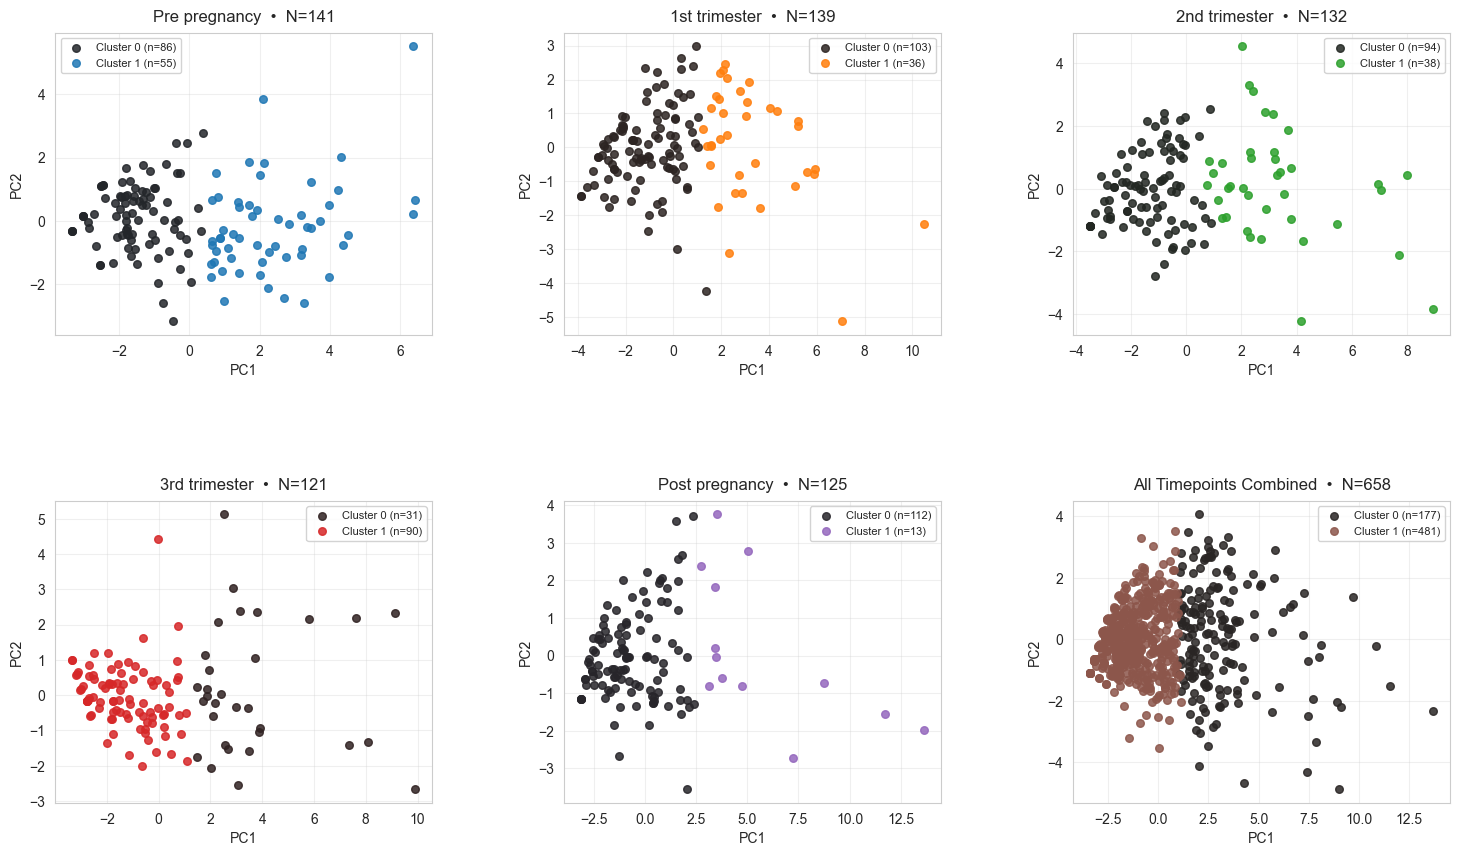

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
import seaborn as sns # נדרש עבור _pick_palette_for_labels

# ===================================================================
#           חלק 1: הגדרת כל הפונקציות הנדרשות
# ===================================================================

# --- פונקציית עזר 1 (נדרשת ע"י פונקציית השרטוט) ---
def _auto_layout(n, max_cols=3):
    """Calculates the number of rows and columns for subplots."""
    nrows = math.ceil(n / max_cols)
    ncols = min(n, max_cols)
    return nrows, ncols

# --- פונקציית עזר 2 (נדרשת ע"י פונקציית השרטוט) ---
def _pick_palette_for_labels(base_color, unique_labels):
    """Creates a color palette for a set of labels."""
    n_colors = len(unique_labels)
    if n_colors == 1:
        return {unique_labels[0]: base_color}
    try:
        # שימוש בפלטה כהה כדי להבדיל אשכולות
        colors = sns.dark_palette(base_color, n_colors=n_colors)
        return {lab: color for lab, color in zip(unique_labels, colors)}
    except Exception:
        # Fallback
        colors = sns.color_palette(n_colors=n_colors)
        return {lab: color for lab, color in zip(unique_labels, colors)}



    return labels, data_pca, kmeans, pca

# --- פונקציה 2: שרטוט מרובה פאנלים (כפי שסיפקת) ---
def plot_multi_dataset_scatters_colored(
    datasets,
    titles=None,
    labels_list=None,
    x_idx=0,
    y_idx=1,
    figsize=(18, 10),
    point_size=30,
    alpha=0.85,
    base_colors=None,
    wspace=0.35,
    hspace=0.55,
    axes_bg="white",
    max_cols=3,
    legend_loc="best",
    sort_labels=True,
    show_counts=True,
    show_percent=False
):
    """
    Draw multiple PCA scatter panels, coloring by clusters. Adds cluster counts to legend.
    """
    n = len(datasets)
    if base_colors is None:
        base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                       "tab:purple", "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]

    if len(base_colors) < n:
        cycles_needed = math.ceil(n / len(base_colors))
        base_colors = (base_colors * cycles_needed)[:n]

    nrows, ncols = _auto_layout(n, max_cols=max_cols)
    fig, axes = plt.subplots(
        nrows, ncols, figsize=figsize,
        gridspec_kw={"wspace": wspace, "hspace": hspace}
    )
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for i, data in enumerate(datasets):
        ax = axes[i]
        ax.set_facecolor(axes_bg)

        # בדיקה אם הנתונים קיימים (למקרה של שגיאה בריצה)
        if data is None or labels_list[i] is None:
            ax.text(0.5, 0.5, f"No data for {titles[i] if titles else ''}",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, color='red')
            ax.set_title(titles[i] if titles else '', pad=8)
            continue

        labels = labels_list[i]
        x = data[:, x_idx]
        y = data[:, y_idx]

        labels = np.asarray(labels)
        unique_labels = [lab for lab in np.unique(labels) if lab == lab] # Handles NaNs
        if sort_labels:
            try: unique_labels = np.sort(unique_labels)
            except Exception: pass

        total_n = int(np.sum(~np.isnan(labels))) if np.issubdtype(labels.dtype, np.floating) else len(labels)
        palette = _pick_palette_for_labels(base_colors[i], unique_labels)

        for lab in unique_labels:
            mask = labels == lab
            n_lab = int(np.sum(mask))
            if n_lab == 0: continue
            legend_text = f"Cluster {lab}"
            if show_counts:
                if show_percent and total_n > 0:
                    legend_text += f" (n={n_lab}, {n_lab/total_n:.0%})"
                else:
                    legend_text += f" (n={n_lab})"

            ax.scatter(
                x[mask], y[mask],
                s=point_size, alpha=alpha,
                color=palette[lab], label=legend_text
            )

        ax.legend(fontsize=8, frameon=True, framealpha=0.85, loc=legend_loc)
        ax.set_xlabel(f"PC{x_idx+1}")
        ax.set_ylabel(f"PC{y_idx+1}")
        if titles is not None and i < len(titles):
            ttl = titles[i]
            ttl = f"{ttl}  •  N={total_n}" if show_counts else ttl
            ax.set_title(ttl, pad=8)
        ax.grid(alpha=0.3)

    # כיבוי צירים ריקים (אם יש 6 פאנלים, זה לא יקרה)
    for j in range(len(datasets), nrows * ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show() # הצגת הגרף המאוחד

# ===================================================================
#           חלק 2: הרצת הניתוח
# ===================================================================


# --- שלב ב': הרצת הלולאה עבור כל נקודת זמן ---
# הגדרת סדר נקודות הזמן והכותרות
timepoint_map = {
    'b': "Pre pregnancy",
    't1': "1st trimester",
    't2': "2nd trimester",
    't3': "3rd trimester",
    'after': "Post pregnancy"
}
plot_order = ['b', 't1', 't2', 't3', 'after'] # הסדר הרצוי לפאנלים

results_by_timepoint = {}

print("\n--- Running clustering for EACH timepoint ---")
for tp in plot_order:
    if tp not in df_combined['timepoint'].unique():
        print(f"Warning: Timepoint '{tp}' not found in df_combined. Skipping.")
        results_by_timepoint[tp] = {'labels': None, 'data_pca': None} # Placeholder
        continue

    print(f"\n================ Running for timepoint: {tp} ================")
    df_t = df_combined[df_combined['timepoint'] == tp].copy()

    csv_path_t = f"data/only_Q_outputs/combined/clusters_{tp}.csv"
    title_t = f"Kmeans clustering - {timepoint_map[tp]}"

    # (שים לב: plot=True כאן יציג גרף נפרד *לכל* נקודת זמן)
    labels_t, data_pca_t, model_t, pca_t = run_kmeans_clustering(
        df=df_t,
        prefix="",
        n_components=n_dims_comb_90,
        k=best_k_comb_sil,
        plot=True, # <-- שנה ל-False אם אינך רוצה לראות 5 גרפים נפרדים
        title=title_t,
        csv_path=csv_path_t
    )

    results_by_timepoint[tp] = {
        'labels': labels_t,
        'data_pca': data_pca_t
    }

print("\n✅ All timepoints processed.")

# --- שלב ג': איסוף התוצאות והכנה לשרטוט המאוחד ---
print("--- Generating final 2x3 combined plot ---")

# בניית הרשימות עבור פונקציית השרטוט
datasets_to_plot = [results_by_timepoint[tp]['data_pca'] for tp in plot_order]
labels_to_plot = [results_by_timepoint[tp]['labels'] for tp in plot_order]
titles_for_plot = [timepoint_map[tp] for tp in plot_order]

# הוספת הפריט השישי (המשולב)
datasets_to_plot.append(data_pca_comb_sil)
labels_to_plot.append(labels_comb_sil)
titles_for_plot.append("All Timepoints Combined")

# הגדרת 6 צבעי בסיס
base_colors_for_plot = [
    "tab:blue", "tab:orange", "tab:green",
    "tab:red", "tab:purple", "tab:brown"
]

# --- שלב ד': קריאה לפונקציית השרטוט המאוחד ---
plot_multi_dataset_scatters_colored(
    datasets=datasets_to_plot,
    titles=titles_for_plot,
    labels_list=labels_to_plot,
    x_idx=0, y_idx=1,
    base_colors=base_colors_for_plot,
    show_counts=True,
    show_percent=False,
    max_cols=3 # מבטיח גריד של 2x3
)

## plot the clustering of the combined dataset


C:\Users\nogag\AppData\Local\Temp\ipykernel_27500\4105670899.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


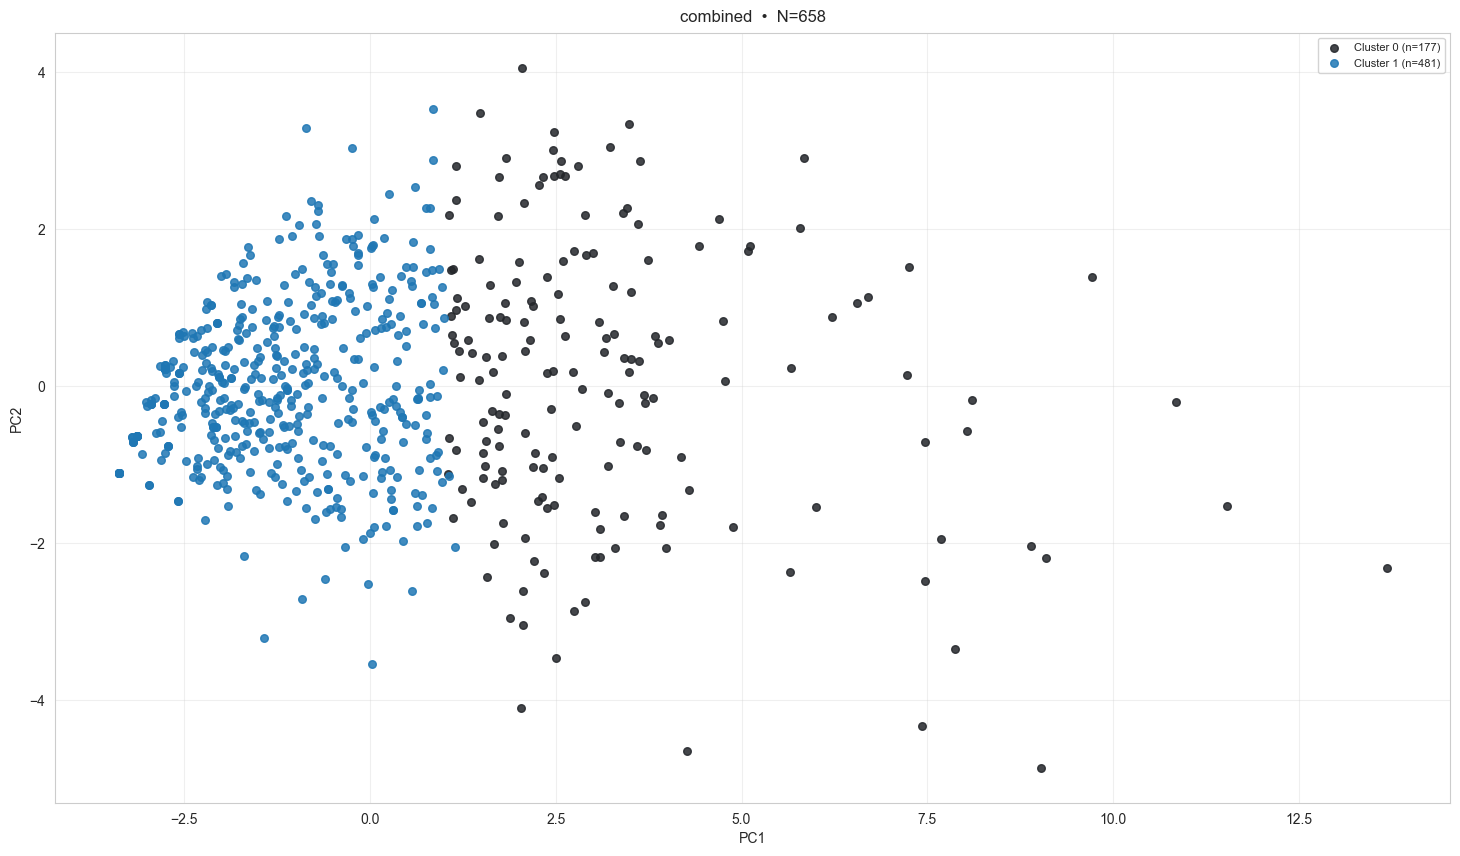

In [20]:
plot_multi_dataset_scatters_colored(
    datasets=[data_pca_comb_sil],
    titles=["combined"],
    labels_list=[labels_comb_sil],
    x_idx=0, y_idx=1,
    base_colors=["tab:blue"],
    show_counts=True,  # <-- on
    show_percent=False  # <-- optional %
)

## plotting the losings for pc1 and pc2

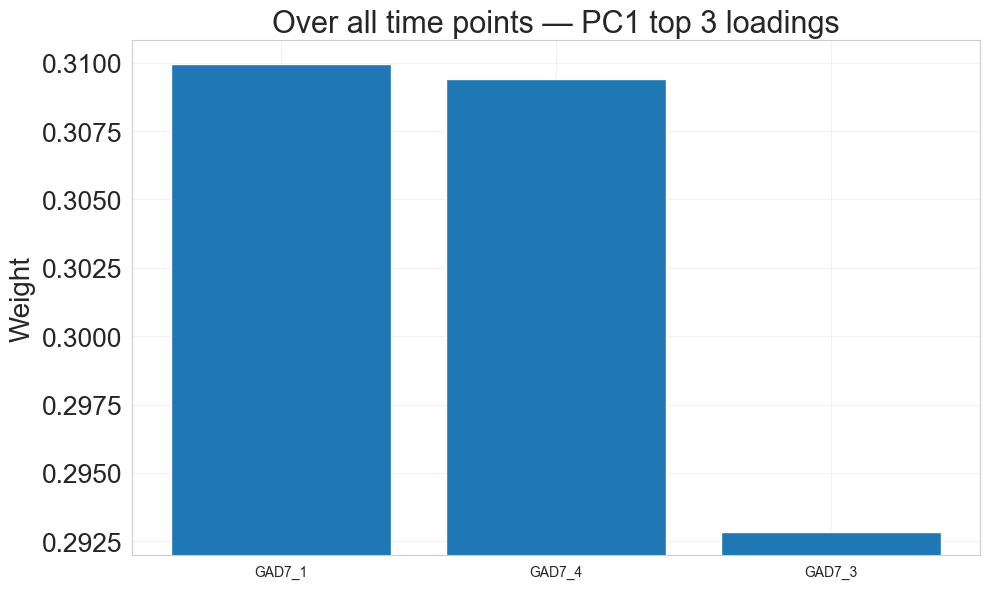

                dataset  pc  rank_within_dataset feature   loading  \
0  Over all time points   1                    1  GAD7_1  0.309961   
1  Over all time points   1                    2  GAD7_4  0.309399   
2  Over all time points   1                    3  GAD7_3  0.292849   

   abs_loading  
0     0.309961  
1     0.309399  
2     0.292849  


In [21]:
# PC1 (pc_index=0), top 15:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_comb_sil],
    dfs=[df_combined],
    prefixes=[""],
    titles=["Over all time points"],
    pc_index=0,
    top_n=3,
    figsize=(10, 6),
    fontsize=20,
    save_csv_path="data/only_Q_outputs/combined/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

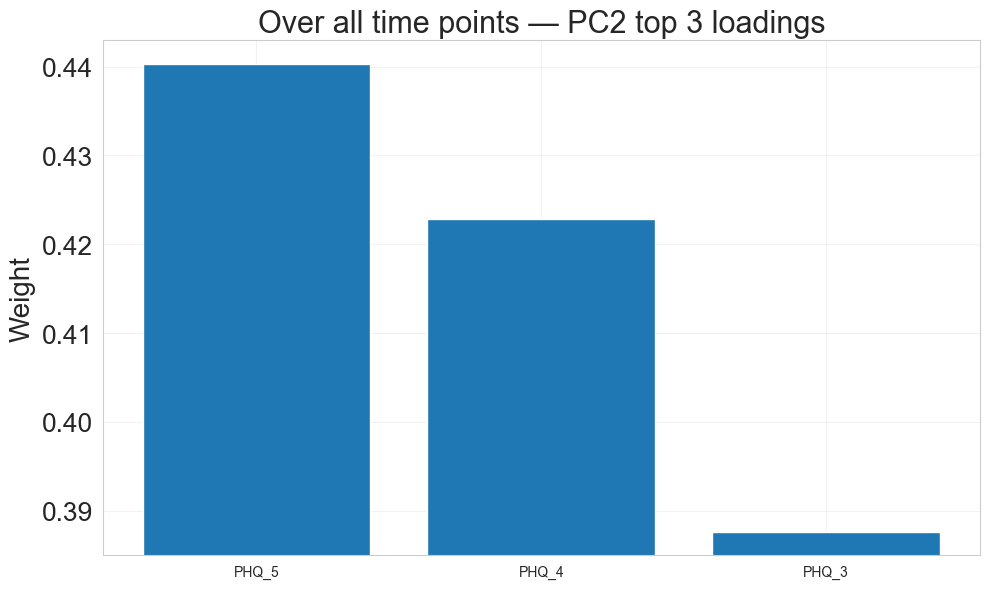

                dataset  pc  rank_within_dataset feature   loading  \
0  Over all time points   2                    1   PHQ_5  0.440313   
1  Over all time points   2                    2   PHQ_4  0.422862   
2  Over all time points   2                    3   PHQ_3  0.387637   

   abs_loading  
0     0.440313  
1     0.422862  
2     0.387637  


In [22]:
df_pc1 = plot_pca_weights_separate_and_table(
    pcas=[pca_comb_sil],
    dfs=[df_combined],
    prefixes=[""],
    titles=["Over all time points"],
    pc_index=1,
    top_n=3,
    figsize=(10, 6),
    fontsize=20,
    save_csv_path="data/only_Q_outputs/combined/top_loadings_PC1.csv"  # או "top_loadings_PC1.csv"
)

# הצצה לטבלה:
print(df_pc1.head(10))

## merge the lcusters from the diffrent time points into one csv

In [23]:
# Map each file to the column name you want in the merged table
files = {
    "data/only_Q_outputs/combined/clusters_b.csv": "before",
    "data/only_Q_outputs/combined/clusters_t1.csv": "t1",
    "data/only_Q_outputs/combined/clusters_t2.csv": "t2",
    "data/only_Q_outputs/combined/clusters_t3.csv": "t3",
    "data/only_Q_outputs/combined/clusters_after.csv": "after",

}


# Load and prepare all dataframes
dfs = [load_one(path, col) for path, col in files.items()]

# Outer-join on Subject_Code
merged = reduce(lambda left, right: pd.merge(left, right, on="Subject_Code", how="outer"), dfs)

# Replace NaN with None (optional)
merged = merged.where(pd.notna(merged), None)

# Save
merged.to_csv('data/only_Q_outputs/combined/clusters_merged_by_subject_from_combined.csv', index=False)
print("Saved: clusters_merged_by_subject.csv")
print(merged.head())

Saved: clusters_merged_by_subject.csv
  Subject_Code  before   t1   t2   t3  after
0        CT002     0.0  NaN  NaN  NaN    NaN
1        CT003     1.0  0.0  0.0  1.0    0.0
2        CT004     0.0  0.0  0.0  1.0    0.0
3        CT005     1.0  1.0  0.0  0.0    0.0
4        CT007     1.0  1.0  1.0  0.0    0.0


## aligning the clusters


In [24]:
invert_binary_columns(
    input_path="data/only_Q_outputs/combined/clusters_merged_by_subject_from_combined.csv",
    output_path='data/only_Q_outputs/combined/timepoints_file_inverted_2.csv',
    column_names=["t3"]  # any set of binary columns
)

invert_binary_columns(
    input_path="data/only_Q_outputs/combined/clusters_combined.csv",
    output_path='data/only_Q_outputs/combined/combined_file_inverted_2.csv',
    column_names=["Cluster"]  # any set of binary columns
)



✅ File saved to data/only_Q_outputs/combined/timepoints_file_inverted_2.csv
✅ File saved to data/only_Q_outputs/combined/combined_file_inverted_2.csv


## kmeans and plotting per timepoint on the combined dataset

## ceating megred file of the clusters and the regression parameters before and adter pragnancy


In [25]:
import pandas as pd

# -----------------------------
# 1. Load the Excel file
# -----------------------------
excel_path = r"data/q_data/Study_Questionnaire_Responses_October.xlsx"
df = pd.read_excel(excel_path)

# -----------------------------
# 2. Load the list of allowed Subject_Code
# -----------------------------
allowed_path = r"data/only_Q_outputs/combined/clusters_combined.csv"
allowed_df = pd.read_csv(allowed_path)

id_col = "Subject_Code"

# Extract allowed subject IDs
allowed_ids = allowed_df[id_col].dropna().unique()

# -----------------------------
# 3. Filter the main Excel file by allowed subjects
# -----------------------------
filtered = df[df[id_col].isin(allowed_ids)].copy()

# -----------------------------
# 4. Choose which columns from Excel to keep
#    Put your desired column names here
# -----------------------------

selected_columns = [
    "Subject_Code"
,'b_DERS_total','b_DES_average','after_DES_total','after_DERS_total'
]

# Keep only the selected columns (if they exist)
available_selected = [c for c in selected_columns if c in filtered.columns]
missing_columns = [c for c in selected_columns if c not in filtered.columns]

if missing_columns:
    print("Warning: These selected columns do not exist in the Excel file:", missing_columns)

filtered = filtered[available_selected]

# -----------------------------
# 5. Save the result to CSV
# -----------------------------
output_path = r"data/only_Q_outputs/combined/regression_parameters.csv"
filtered.to_csv(output_path, index=False)

print("Saved filtered CSV to:", output_path)


Saved filtered CSV to: data/only_Q_outputs/combined/regression_parameters.csv


## ttest des ders on data after


## ttest des ders on data before


columns_to_select = ['b_ctq_total','b_LHQ_total', 'b_DES_average','b_DERS_total', 't1_MAAS_total','t1_DES_total','t2_MAAS_total','t3_MAAS_total'
,'after_MPAS_total','after_DES_total','after_LHQ_total','after_DERS_total',
        "b_ctq_sexual_abuse",
        "b_ctq_physical_abuse",
        "b_ctq_emotional_abuse",
        "b_ctq_physical_neglect",
        "b_ctq_emotional_neglect" ,
        "b_ctq_ABUSE  ",
        "b_ctq_NEGLECT",
        "b_DERS_Nonacceptance_Emotional_Responses",
        "b_DERS_Goal_Directed_Behavior",
        "b_DERS_Impulse_Control",
        "b_DERS_Lack_Emotional_Awareness",
        "b_DERS_Emotion_Regulation_Strategies",
        "b_DERS_Lack_Emotional_Clarity" ,
        "b_DES_Absorption ",
        "b_DES_Amnesia",
        "b_DES_Depersonalization ",
        "after_DERS_Nonacceptance_Emotional_Responses",
        "after_DERS_Goal_Directed_Behavior",
        "after_DERS_Impulse_Control",
        "after_DERS_Lack_Emotional_Awareness",
        "after_DERS_Emotion_Regulation_Strategies",
        "after_DERS_Lack_Emotional_Clarity" ,
        'after_DES_Absorption ',
        'after_DES_Amnesia',
        'after_DES_Depersonalization ','after_CTQ_total',
        "after_CTQ_sexual_abuse",
        "after_CTQ_physical_abuse",
        "after_CTQ_emotional_abuse",
        "after_CTQ_physical_neglect",
        "after_CTQ_emotional_neglect" ,
        "after_CTQ_ABUSE  ",
        "after_CTQ_NEGLECT"]

## pca again od specfied time ponts

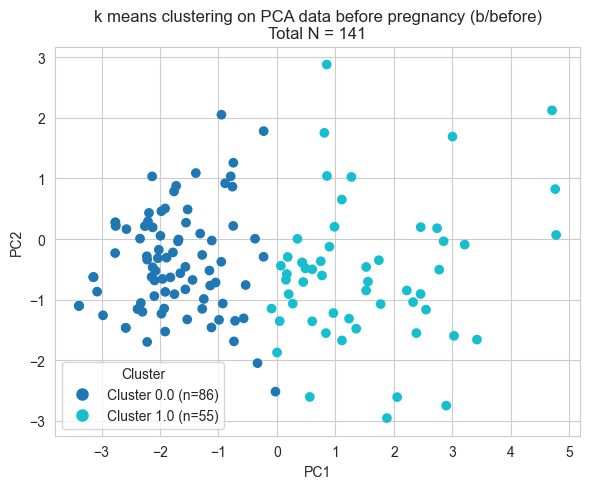

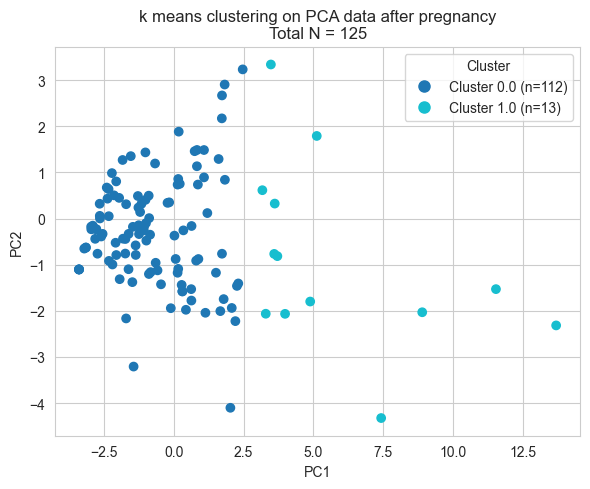

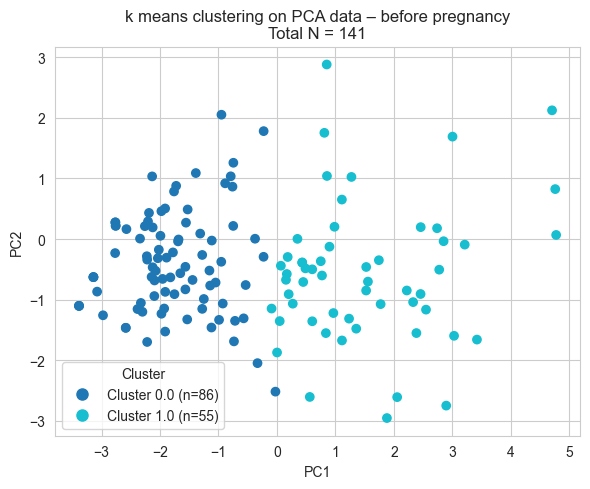

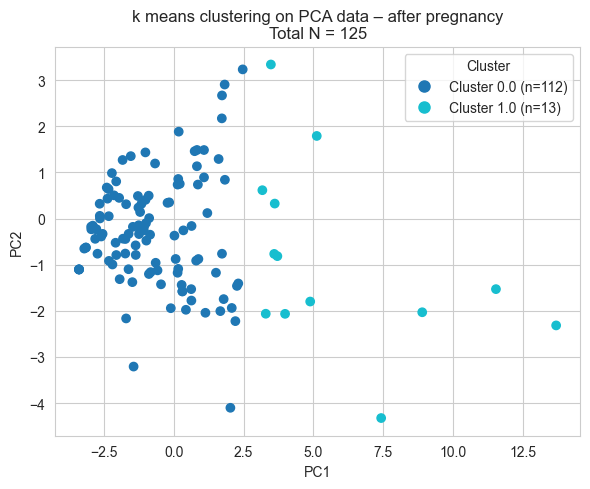

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Read the files
# -------------------------

pca_path = r"data/only_Q_outputs/combined/combined_pca_components.csv"
clusters_path = r"data/only_Q_outputs/combined/timepoints_file_inverted_2.csv"

pca_df = pd.read_csv(pca_path)
clusters_df = pd.read_csv(clusters_path)

# -------------------------
# 2. Helper: plot PCA for ONE timepoint
# -------------------------

def plot_pca_for_timepoint(
    pca_df,
    clusters_df,
    pca_timepoint,
    cluster_col_name,
    pc_x="PC1",
    pc_y="PC2",
    title=None,
    figsize=(6, 5)
):

    sub_pca = pca_df[pca_df["timepoint"] == pca_timepoint].copy()
    if sub_pca.empty:
        print(f"No PCA rows for timepoint '{pca_timepoint}' – skipping.")
        return

    if cluster_col_name not in clusters_df.columns:
        print(f"Cluster column '{cluster_col_name}' not found – skipping.")
        return

    clust_sub = clusters_df[["Subject_Code", cluster_col_name]].copy()
    clust_sub = clust_sub.dropna(subset=[cluster_col_name])

    merged = pd.merge(sub_pca, clust_sub, on="Subject_Code", how="inner")
    merged = merged.rename(columns={cluster_col_name: "Cluster"})

    if merged.empty:
        print(f"No overlap for timepoint '{pca_timepoint}'")
        return

    total_n = len(merged)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        merged[pc_x],
        merged[pc_y],
        c=merged["Cluster"],
        cmap="tab10"
    )

    # --------------------------------------------------------
    # FIXED LEGEND: TRUE COUNTS PER CLUSTER
    # --------------------------------------------------------
    cluster_counts = merged["Cluster"].value_counts().sort_index()

    handles = []
    labels = []

    for cl in cluster_counts.index:
        color = plt.cm.tab10(cl % 10)

        handles.append(
            plt.Line2D([], [], marker='o', color=color, linestyle='', markersize=8)
        )
        labels.append(f"Cluster {cl} (n={cluster_counts[cl]})")

    plt.legend(handles, labels, title="Cluster")
    # --------------------------------------------------------

    if title is None:
        title = f"PCA clustering ({pca_timepoint}/{cluster_col_name})"

    plt.title(f"{title}\nTotal N = {total_n}")
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)


    plt.tight_layout()
    plt.show()



# -------------------------
# 3. Examples of usage
# -------------------------

# "before pregnancy": PCA uses 'b', clusters file uses 'before'
plot_pca_for_timepoint(
    pca_df,
    clusters_df,
    pca_timepoint="b",
    cluster_col_name="before",
    pc_x="PC1",
    pc_y="PC2",
    title="k means clustering on PCA data before pregnancy (b/before)"
)

# "after pregnancy": both PCA and clusters use 'after'
plot_pca_for_timepoint(
    pca_df,
    clusters_df,
    pca_timepoint="after",
    cluster_col_name="after",
    pc_x="PC1",
    pc_y="PC2",
    title="k means clustering on PCA data after pregnancy"
)

# If later you have more mappings, you can loop:
timepoint_mapping = {
    "b": "before",
    "after": "after",
    # "t1": "t1", etc...
}

for pca_tp, cluster_col in timepoint_mapping.items():
    plot_pca_for_timepoint(
        pca_df,
        clusters_df,
        pca_timepoint=pca_tp,
        cluster_col_name=cluster_col,
        pc_x="PC1",
        pc_y="PC2",
        title=f"k means clustering on PCA data – {cluster_col} pregnancy"
    )


## creating a file with clusters and parmeters to check

In [27]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

timepoints_path = r"data/only_Q_outputs/combined/timepoints_file_inverted_2.csv"
regression_path = r"data/only_Q_outputs/combined/regression_parameters.csv"

time_df = pd.read_csv(timepoints_path)
reg_df = pd.read_csv(regression_path)

# -------------------------
# 2. Choose columns from regression_parameters
#    Make sure "Subject_Code" is included
# -------------------------

regression_cols = [
    "Subject_Code"
    # add here the parameter columns you want from the regression file, e.g.:
   ,'b_DERS_total','b_DES_average','after_DES_total','after_DERS_total'
]

reg_sel = reg_df[regression_cols].copy()

# helper: list of regression columns WITHOUT Subject_Code
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Filter subjects that have value in column 'b' / 'after'
#    Here "have value" = not NaN. If in your file it's 0/1, you can change to != 0.
# -------------------------

# subjects with value in column 'b'
b_subjects = time_df[time_df["before"].notna()].copy()
# e.g. if it's 0/1 then:
# b_subjects = time_df[time_df["b"] != 0].copy()

# subjects with value in column 'after'
after_subjects = time_df[time_df["after"].notna()].copy()
# or if it's 0/1:
# after_subjects = time_df[time_df["after"] != 0].copy()

# -------------------------
# 4. Merge with regression parameters on Subject_Code
# -------------------------

b_merged_full = pd.merge(
    b_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

after_merged_full = pd.merge(
    after_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Keep ONLY:
#    Subject_Code + wanted timepoint column + regression parameters
# -------------------------

b_final = b_merged_full[["Subject_Code", "before"] + reg_param_cols].copy()
after_final = after_merged_full[["Subject_Code", "after"] + reg_param_cols].copy()

# -------------------------
# 6. Save the two final files
# -------------------------
b_final = b_final.rename(columns={"before": "cluster"})
after_final = after_final.rename(columns={"after": "cluster"})

b_output_path = r"data/only_Q_outputs/combined/subjects_b_with_regression_clean.csv"
after_output_path = r"data/only_Q_outputs/combined/subjects_after_with_regression_clean.csv"

b_final.to_csv(b_output_path, index=False)
after_final.to_csv(after_output_path, index=False)

print("Saved:")
print(" -", b_output_path)
print(" -", after_output_path)


Saved:
 - data/only_Q_outputs/combined/subjects_b_with_regression_clean.csv
 - data/only_Q_outputs/combined/subjects_after_with_regression_clean.csv


## taking the dsta from after pregnancy and trying to predict the after parmeters

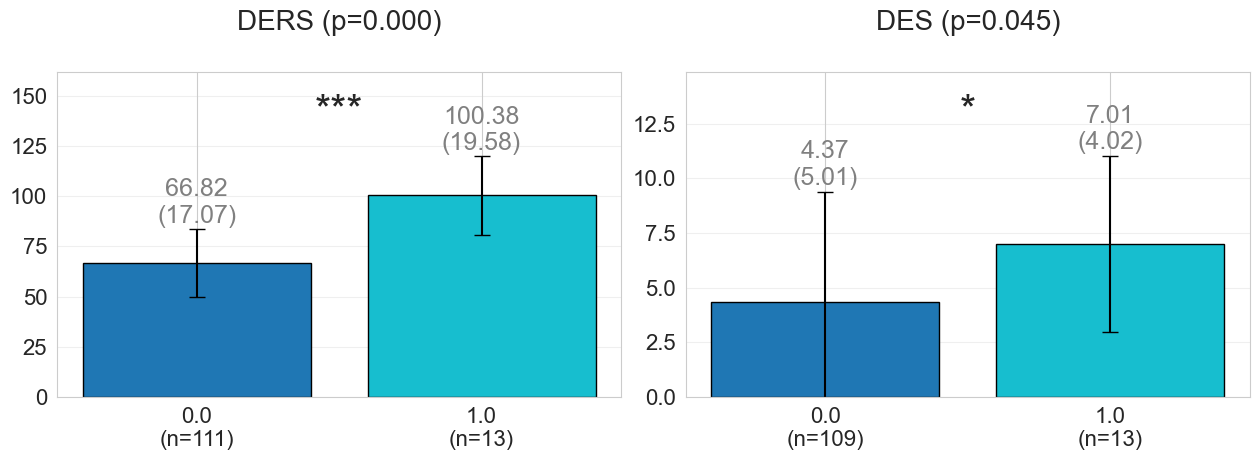

           variable      mean0       std0   n0       mean1       std1  n1  \
0  after_DERS_total  66.819820  17.066820  111  100.384615  19.581192  13   
1   after_DES_total   4.370904   5.013893  109    7.005495   4.018290  13   

      p_raw stars  
0  0.000035   ***  
1  0.044554     *  


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

# --------------------------------------------------
# GLOBAL FONT SETTINGS – makes EVERYTHING bigger
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 20,         # default font size
    'axes.titlesize': 20,    # subplot titles
    'axes.labelsize': 18,    # axis labels
    'xtick.labelsize': 16,   # x-axis ticks
    'ytick.labelsize': 16,   # y-axis ticks
})

# --------------------------------------------------
# 1. Load your data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/combined/subjects_after_with_regression_clean.csv")

cluster_col = "cluster"

value_cols = [
    "after_DERS_total",
    "after_DES_total"
]


# --------------------------------------------------
# 2. Clean variable names
# --------------------------------------------------
def clean_variable_name(var):
    """
    Example:
        after_DERS_total -> DERS
        after_DES_total  -> DES
    """
    parts = var.split("_")
    if len(parts) >= 3:
        return parts[1]  # the middle part
    return var


# --------------------------------------------------
# 3. Analysis & Plotting Function (NO FDR)
# --------------------------------------------------
def compare_clusters_no_fdr(
    df,
    cluster_col,
    value_cols
):
    df = df.dropna(subset=[cluster_col]).copy()

    # Colors
    cluster_values = sorted(df[cluster_col].unique())
    base_colors = ["#1f77b4", "#17becf"]
    color_map = {cluster_values[i]: base_colors[i % 2] for i in range(len(cluster_values))}

    stats_list = []

    for col in value_cols:
        g0 = df[df[cluster_col] == cluster_values[0]][col].dropna()
        g1 = df[df[cluster_col] == cluster_values[1]][col].dropna()

        _, p = ttest_ind(g0, g1, equal_var=False, nan_policy="omit")

        stats_list.append({
            "variable": col,
            "mean0": g0.mean(),
            "std0": g0.std(),
            "n0": g0.size,
            "mean1": g1.mean(),
            "std1": g1.std(),
            "n1": g1.size,
            "p_raw": p,
            "stars": "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        })

    n_vars = len(value_cols)
    fig, axes = plt.subplots(1, n_vars, figsize=(13, 5))
    axes = np.array(axes).flatten()

    for ax, s in zip(axes, stats_list):

        means = [s["mean0"], s["mean1"]]
        stds  = [s["std0"], s["std1"]]
        ns    = [s["n0"], s["n1"]]

        x = np.arange(2)
        bar_colors = [color_map[cluster_values[0]], color_map[cluster_values[1]]]

        ax.bar(x, means, yerr=stds, capsize=6, color=bar_colors, edgecolor="black")

        ax.set_xticks(x)
        ax.set_xticklabels([
            f"{cluster_values[0]}\n(n={ns[0]})",
            f"{cluster_values[1]}\n(n={ns[1]})"
        ])

        y_top = max(m + sd for m, sd in zip(means, stds))
        ax.set_ylim(0, y_top * 1.35)

        ax.text(0.5, y_top * 1.18, s["stars"], ha="center", va="center", fontsize=30)

        for xi, m, sd in zip(x, means, stds):
            ax.text(xi, m + sd * 1.02, f"{m:.2f}\n({sd:.2f})",
                    ha="center", va="bottom", fontsize=18, color="gray")

        clean_name = clean_variable_name(s["variable"])
        ax.set_title(f"{clean_name} (p={s['p_raw']:.3f})", pad=30)

        ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(stats_list)


# --------------------------------------------------
# 4. Run it
# --------------------------------------------------
results_df = compare_clusters_no_fdr(
    df,
    cluster_col=cluster_col,
    value_cols=value_cols
)

print(results_df)


## taking the data from before pregnancy and trying to predict the before parmeters


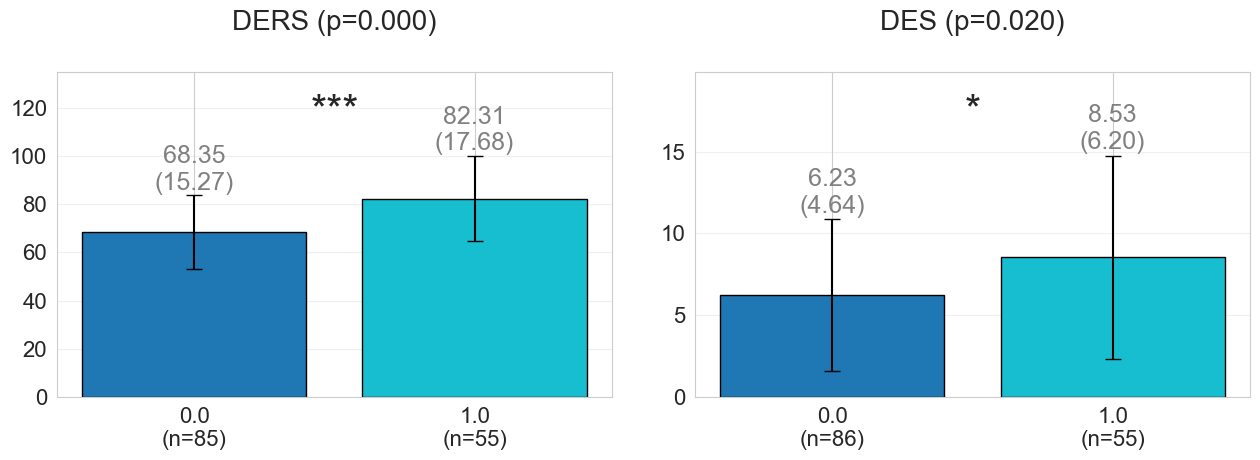

        variable      mean0       std0  n0      mean1       std1  n1  \
0   b_DERS_total  68.352941  15.272685  85  82.309091  17.681202  55   
1  b_DES_average   6.225083   4.636402  86   8.532468   6.202550  55   

      p_raw stars  
0  0.000005   ***  
1  0.019976     *  


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import math

# --------------------------------------------------
# GLOBAL FONT SETTINGS – makes EVERYTHING bigger
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 20,         # default font size
    'axes.titlesize': 20,    # subplot titles
    'axes.labelsize': 18,    # axis labels
    'xtick.labelsize': 16,   # x-axis ticks
    'ytick.labelsize': 16,   # y-axis ticks
})

# --------------------------------------------------
# 1. Load your data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/combined/subjects_b_with_regression_clean.csv")

cluster_col = "cluster"

value_cols = [
    "b_DERS_total",
    "b_DES_average"
]


# --------------------------------------------------
# 2. Clean variable names
# --------------------------------------------------
def clean_variable_name(var):
    """
    Example:
        after_DERS_total -> DERS
        after_DES_total  -> DES
    """
    parts = var.split("_")
    if len(parts) >= 3:
        return parts[1]  # the middle part
    return var


# --------------------------------------------------
# 3. Analysis & Plotting Function (NO FDR)
# --------------------------------------------------
def compare_clusters_no_fdr(
    df,
    cluster_col,
    value_cols
):
    df = df.dropna(subset=[cluster_col]).copy()

    # Colors
    cluster_values = sorted(df[cluster_col].unique())
    base_colors = ["#1f77b4", "#17becf"]
    color_map = {cluster_values[i]: base_colors[i % 2] for i in range(len(cluster_values))}

    stats_list = []

    for col in value_cols:
        g0 = df[df[cluster_col] == cluster_values[0]][col].dropna()
        g1 = df[df[cluster_col] == cluster_values[1]][col].dropna()

        _, p = ttest_ind(g0, g1, equal_var=False, nan_policy="omit")

        stats_list.append({
            "variable": col,
            "mean0": g0.mean(),
            "std0": g0.std(),
            "n0": g0.size,
            "mean1": g1.mean(),
            "std1": g1.std(),
            "n1": g1.size,
            "p_raw": p,
            "stars": "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        })

    n_vars = len(value_cols)
    fig, axes = plt.subplots(1, n_vars, figsize=(13, 5))
    axes = np.array(axes).flatten()

    for ax, s in zip(axes, stats_list):

        means = [s["mean0"], s["mean1"]]
        stds  = [s["std0"], s["std1"]]
        ns    = [s["n0"], s["n1"]]

        x = np.arange(2)
        bar_colors = [color_map[cluster_values[0]], color_map[cluster_values[1]]]

        ax.bar(x, means, yerr=stds, capsize=6, color=bar_colors, edgecolor="black")

        ax.set_xticks(x)
        ax.set_xticklabels([
            f"{cluster_values[0]}\n(n={ns[0]})",
            f"{cluster_values[1]}\n(n={ns[1]})"
        ])

        y_top = max(m + sd for m, sd in zip(means, stds))
        ax.set_ylim(0, y_top * 1.35)

        ax.text(0.5, y_top * 1.18, s["stars"], ha="center", va="center", fontsize=30)

        for xi, m, sd in zip(x, means, stds):
            ax.text(xi, m + sd * 1.02, f"{m:.2f}\n({sd:.2f})",
                    ha="center", va="bottom", fontsize=18, color="gray")

        clean_name = clean_variable_name(s["variable"])
        ax.set_title(f"{clean_name} (p={s['p_raw']:.3f})", pad=30)

        ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(stats_list)


# --------------------------------------------------
# 4. Run it
# --------------------------------------------------
results_df = compare_clusters_no_fdr(
    df,
    cluster_col=cluster_col,
    value_cols=value_cols
)

print(results_df)


## creating merged file for the clusters before the pregnancy + after the pregnancy

In [30]:
import pandas as pd

# -------------------------
# 1. Read before & after files
# -------------------------

before_path = r"data/only_Q_outputs/combined/subjects_b_with_regression_clean.csv"
after_path  = r"data/only_Q_outputs/combined/subjects_after_with_regression_clean.csv"

before_df = pd.read_csv(before_path)
after_df  = pd.read_csv(after_path)

# if your column is 'Subject_code' instead of 'Subject_Code', change here:
id_col = "Subject_Code"

# -------------------------
# 2. Rename cluster columns
# -------------------------

before_df = before_df.rename(columns={"cluster": "clusters_before"})
after_df  = after_df.rename(columns={"cluster": "clusters_after"})

# -------------------------
# 3. Full outer merge on Subject_Code
#    This keeps all subjects from both files
#    Regression columns with the same name get suffixes
# -------------------------

merged = pd.merge(
    before_df,
    after_df,
    on=id_col,
    how="outer",
    suffixes=("_beforefile", "_afterfile")
)

# At this point we have:
# Subject_Code, clusters_before, clusters_after,
# param1_beforefile, param1_afterfile, ...

# -------------------------
# 4. Collapse regression columns:
#    for each param, prefer "beforefile" value,
#    and if it's NaN, use "afterfile" value.
# -------------------------

# find all base regression names from the *_beforefile columns
reg_base_names = [
    col.replace("_beforefile", "")
    for col in merged.columns
    if col.endswith("_beforefile")
]

for base in reg_base_names:
    before_col = f"{base}_beforefile"
    after_col  = f"{base}_afterfile"

    # create a single clean column
    merged[base] = merged.get(before_col).combine_first(merged.get(after_col))

# drop the suffixed regression columns, keep only the clean ones
cols_to_drop = []
for base in reg_base_names:
    bcol = f"{base}_beforefile"
    acol = f"{base}_afterfile"
    if bcol in merged.columns:
        cols_to_drop.append(bcol)
    if acol in merged.columns:
        cols_to_drop.append(acol)

merged = merged.drop(columns=cols_to_drop)

# -------------------------
# 5. Optional: order columns nicely
# -------------------------

# put id + clusters first, then regression parameters
other_cols = [c for c in merged.columns if c not in [id_col, "clusters_before", "clusters_after"]]
merged = merged[[id_col, "clusters_before", "clusters_after"] + other_cols]

# -------------------------
# 6. Save final file
# -------------------------

out_path = r"data/only_Q_outputs/combined/clusters_regression_before_after.csv"
merged.to_csv(out_path, index=False)

print("Saved:", out_path)


Saved: data/only_Q_outputs/combined/clusters_regression_before_after.csv


## doing the cross prediction for the DERS

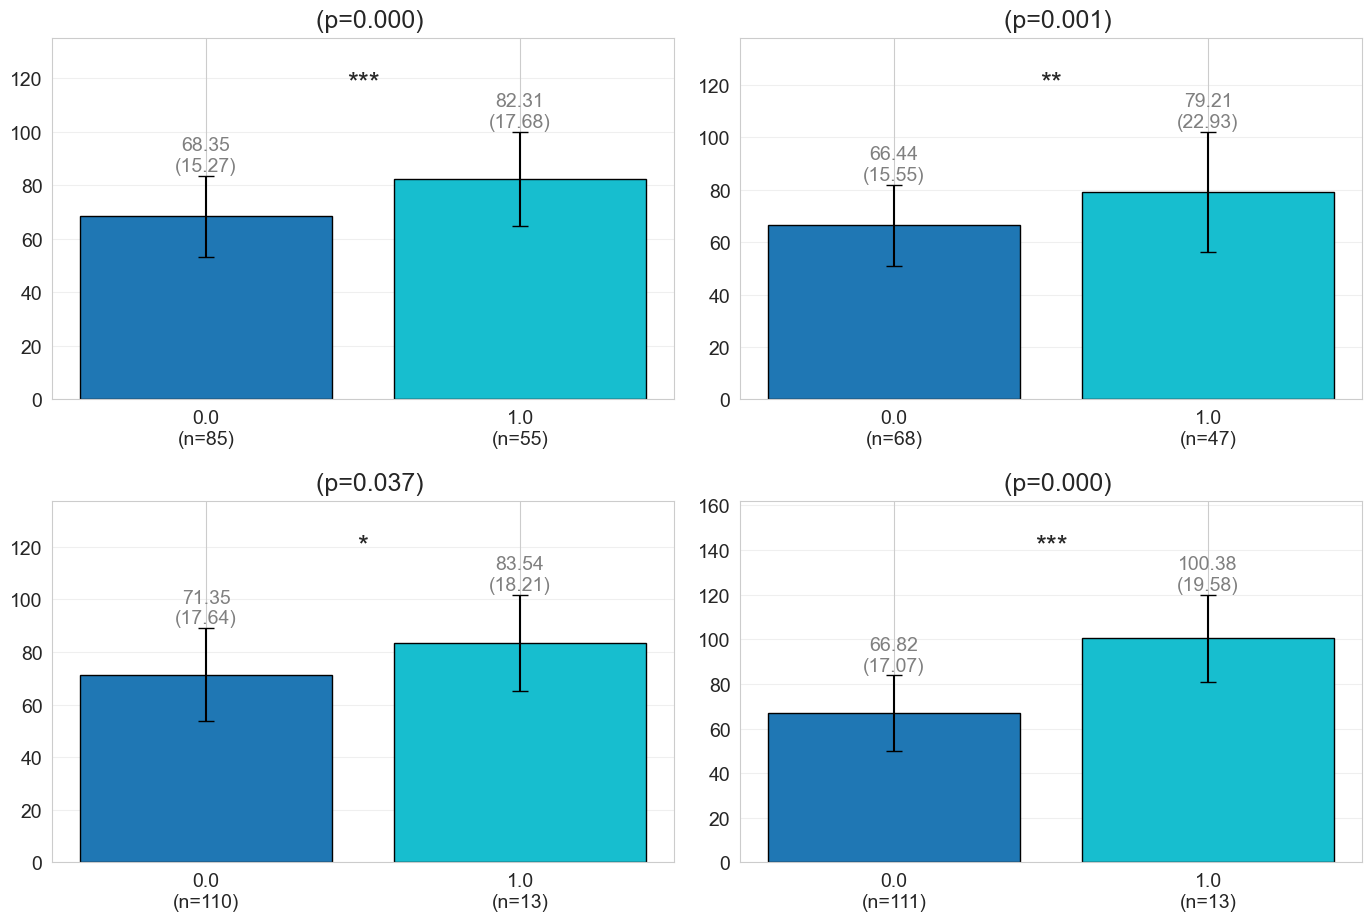

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --------------------------------------------------
# 1. Load data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/combined/clusters_regression_before_after.csv")

comparisons = [
    ("clusters_before", "b_DERS_total"),
    ("clusters_before", "after_DERS_total"),
    ("clusters_after",  "b_DERS_total"),
    ("clusters_after",  "after_DERS_total"),
]

# --------------------------------------------------
# 2. Helper: clean variable names
# --------------------------------------------------
def clean_name(name):
    """
    Converts:
        b_DERS_total     → DERS Before
        after_DERS_total → DERS After
    """
    parts = name.split("_")

    if name.startswith("b_"):
        return f"{parts[1]} Before"

    if name.startswith("after_"):
        return f"{parts[1]} After"

    if name.startswith("clusters"):
        return parts[1].capitalize()

    return name

# --------------------------------------------------
# 3. Helper: stars from raw p-value
# --------------------------------------------------
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# --------------------------------------------------
# 4. Plot (NO FDR)
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

base_colors = ["#1f77b4", "#17becf"]

for i, ((cluster_col, value_col), ax) in enumerate(zip(comparisons, axes)):

    sub = df.dropna(subset=[cluster_col, value_col]).copy()
    clusters = sorted(sub[cluster_col].unique())

    if len(clusters) != 2:
        ax.set_title("No valid data")
        ax.axis("off")
        continue

    # Groups
    g0 = sub[sub[cluster_col] == clusters[0]][value_col].dropna()
    g1 = sub[sub[cluster_col] == clusters[1]][value_col].dropna()

    means = [g0.mean(), g1.mean()]
    stds  = [g0.std(), g1.std()]
    ns    = [g0.size, g1.size]

    # Raw p-value
    _, p_raw = ttest_ind(g0, g1, equal_var=False, nan_policy="omit")
    stars = p_to_stars(p_raw)

    # Colors
    bar_colors = [base_colors[0], base_colors[1]]

    # Bars
    x = np.arange(2)
    ax.bar(x, means, yerr=stds, color=bar_colors, capsize=6, edgecolor="black")

    # X labels
    ax.set_xticks(x)
    ax.set_xticklabels([
        f"{clusters[0]}\n(n={ns[0]})",
        f"{clusters[1]}\n(n={ns[1]})"
    ])

    # Y-limit
    y_top = max(m + sd for m, sd in zip(means, stds))
    ax.set_ylim(0, y_top * 1.35)

    # Stars above graph
    ax.text(0.5, y_top * 1.18, stars, ha="center", va="center", fontsize=20)

    # Mean ± SD
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd * 1.02, f"{m:.2f}\n({sd:.2f})",
                ha="center", va="bottom", fontsize=14, color="gray")

    # Clean names for title
    clean_var = clean_name(value_col)
    clean_cluster = clean_name(cluster_col)

    # Title (moved down)
    ax.set_title(f"  (p={p_raw:.3f})", pad=8)

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## doing the cross prediction for the des

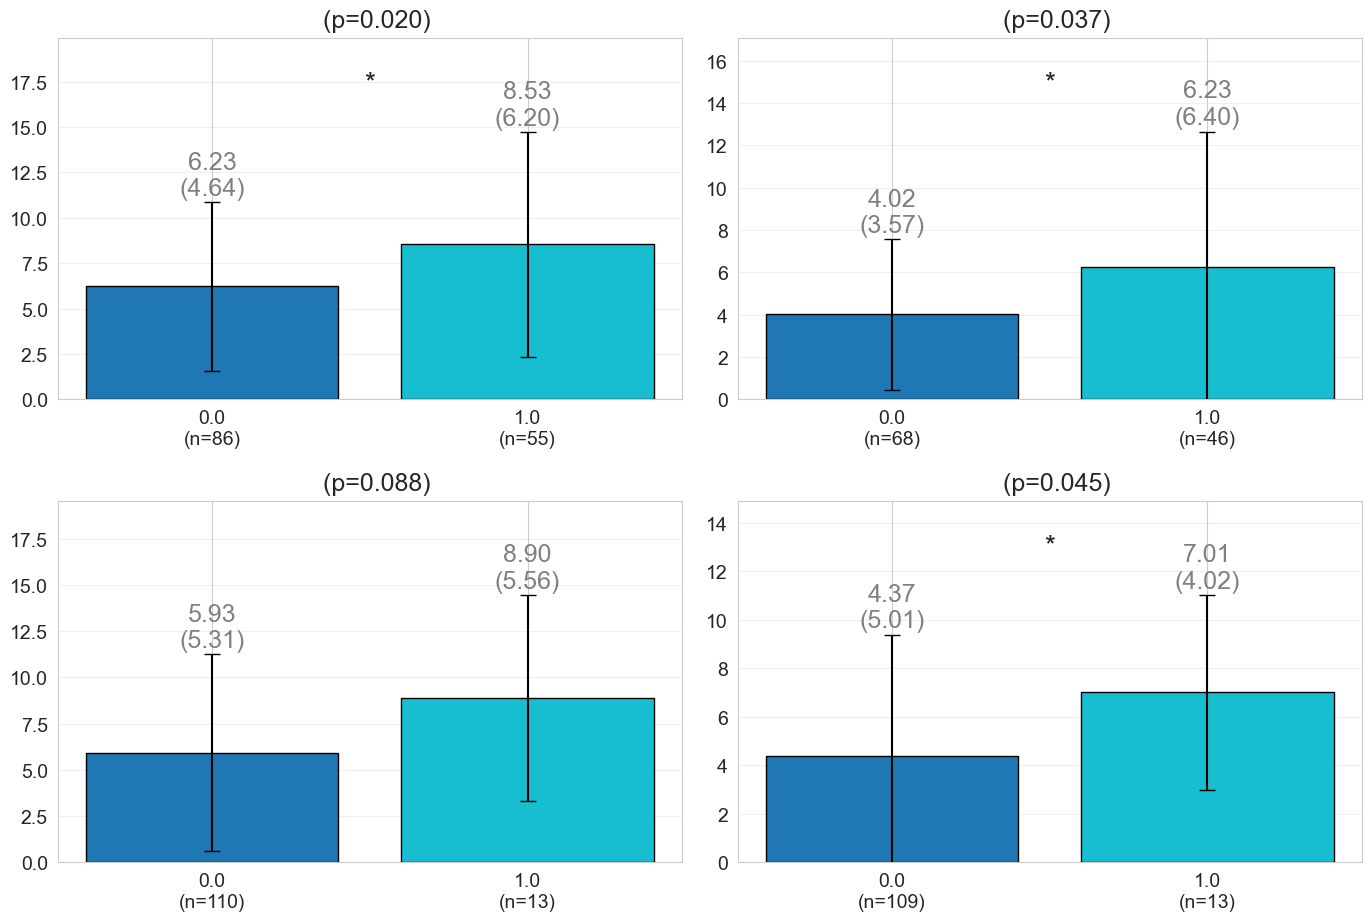

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --------------------------------------------------
# 1. Load data
# --------------------------------------------------
df = pd.read_csv("data/only_Q_outputs/combined/clusters_regression_before_after.csv")

comparisons = [
    ("clusters_before", "b_DES_average"),
    ("clusters_before", "after_DES_total"),
    ("clusters_after",  "b_DES_average"),
    ("clusters_after",  "after_DES_total"),
]

# --------------------------------------------------
# 2. Helper: clean variable names
# --------------------------------------------------
def clean_name(name):
    """
    Converts:
        b_DERS_total     → DERS Before
        after_DERS_total → DERS After
    """
    parts = name.split("_")

    if name.startswith("b_"):
        return f"{parts[1]} Before"

    if name.startswith("after_"):
        return f"{parts[1]} After"

    if name.startswith("clusters"):
        return parts[1].capitalize()

    return name

# --------------------------------------------------
# 3. Helper: stars from raw p-value
# --------------------------------------------------
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# --------------------------------------------------
# 4. Plot (NO FDR)
# --------------------------------------------------
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

base_colors = ["#1f77b4", "#17becf"]

for i, ((cluster_col, value_col), ax) in enumerate(zip(comparisons, axes)):

    sub = df.dropna(subset=[cluster_col, value_col]).copy()
    clusters = sorted(sub[cluster_col].unique())

    if len(clusters) != 2:
        ax.set_title("No valid data")
        ax.axis("off")
        continue

    # Groups
    g0 = sub[sub[cluster_col] == clusters[0]][value_col].dropna()
    g1 = sub[sub[cluster_col] == clusters[1]][value_col].dropna()

    means = [g0.mean(), g1.mean()]
    stds  = [g0.std(), g1.std()]
    ns    = [g0.size, g1.size]

    # Raw p-value
    _, p_raw = ttest_ind(g0, g1, equal_var=False, nan_policy="omit")
    stars = p_to_stars(p_raw)

    # Colors
    bar_colors = [base_colors[0], base_colors[1]]

    # Bars
    x = np.arange(2)
    ax.bar(x, means, yerr=stds, color=bar_colors, capsize=6, edgecolor="black")

    # X labels
    ax.set_xticks(x)
    ax.set_xticklabels([
        f"{clusters[0]}\n(n={ns[0]})",
        f"{clusters[1]}\n(n={ns[1]})"
    ])

    # Y-limit
    y_top = max(m + sd for m, sd in zip(means, stds))
    ax.set_ylim(0, y_top * 1.35)

    # Stars above graph
    ax.text(0.5, y_top * 1.18, stars, ha="center", va="center", fontsize=20)

    # Mean ± SD
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd * 1.02, f"{m:.2f}\n({sd:.2f})",
                ha="center", va="bottom", fontsize=18, color="gray")

    # Clean names for title
    clean_var = clean_name(value_col)
    clean_cluster = clean_name(cluster_col)

    # Title (moved down)
    ax.set_title(f"  (p={p_raw:.3f})", pad=8)

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## creating merged ifile of the pca and the regression parameters

### BEFORE AND REGRESSION PARMETERS

In [33]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"data/only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"data/only_Q_outputs/combined/regression_parameters.csv"
clusters_path = r"data/only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    "b_DERS_total", "b_DES_average", "after_DES_total", "after_DERS_total"
]

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("b", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "before"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"data/only_Q_outputs/combined/subjects_pc_b_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - data/only_Q_outputs/combined/subjects_pc_b_with_regression.csv


### AFTER AND REGRESSION PARMETERS


In [34]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"data/only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"data/only_Q_outputs/combined/regression_parameters.csv"
clusters_path = r"data/only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    "b_DERS_total", "b_DES_average", "after_DES_total", "after_DERS_total"
]

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

pc_df_b = pc_df[pc_df["timepoint"].str.contains("after", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13"]


pc_b = pc_df_b[pc1_cols].copy()


# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "after"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"data/only_Q_outputs/combined/subjects_pc_after_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - data/only_Q_outputs/combined/subjects_pc_after_with_regression.csv


## PREDICTING WITH LASSO AND PC'S

### BEFORE

In [35]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

# -------------------------
# 1. Load the merged dataset
# -------------------------
data_path = r"data/only_Q_outputs/combined/subjects_pc_b_with_regression.csv"
df = pd.read_csv(data_path)
print(df.columns.tolist())
# -------------------------
# 2. Identify predictor PC1 column
# -------------------------
pc_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13"]

# -------------------------
# 3. Targets
# -------------------------
targets = ["b_DERS_total", "b_DES_average", "after_DES_total", "after_DERS_total"]

# Final prediction dataframe
prediction_df = df[["Subject_Code", "cluster"]].copy()

results = {}

for target in targets:

    # Remove NA rows
    valid_df = df[pc_cols + [target]].dropna()
    X = valid_df[pc_cols]
    y = valid_df[target]

    # -------------------------
    # Use ALL data in cross-validation (no manual split)
    # -------------------------
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X, y)

    # Predictions on all subjects
    X_all = df[pc_cols]
    all_preds = lasso.predict(X_all)

    # Compute R2 on full cross-validated fit
    r2 = lasso.score(X, y)

    # Store
    prediction_df[f"pred_{target}"] = all_preds
    prediction_df[f"R2_{target}"] = r2

    results[target] = {
        "alpha": lasso.alpha_,
        "coef_PC1": float(lasso.coef_[0]),
        "intercept": float(lasso.intercept_),
        "R2": r2
    }

# Save file
output_path = r"data/only_Q_outputs/combined/subjects_b_predictions_with_r2.csv"
prediction_df.to_csv(output_path, index=False)

print("Saved:", output_path)


['Subject_Code', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'b_DERS_total', 'b_DES_average', 'after_DES_total', 'after_DERS_total', 'cluster']
Saved: data/only_Q_outputs/combined/subjects_b_predictions_with_r2.csv


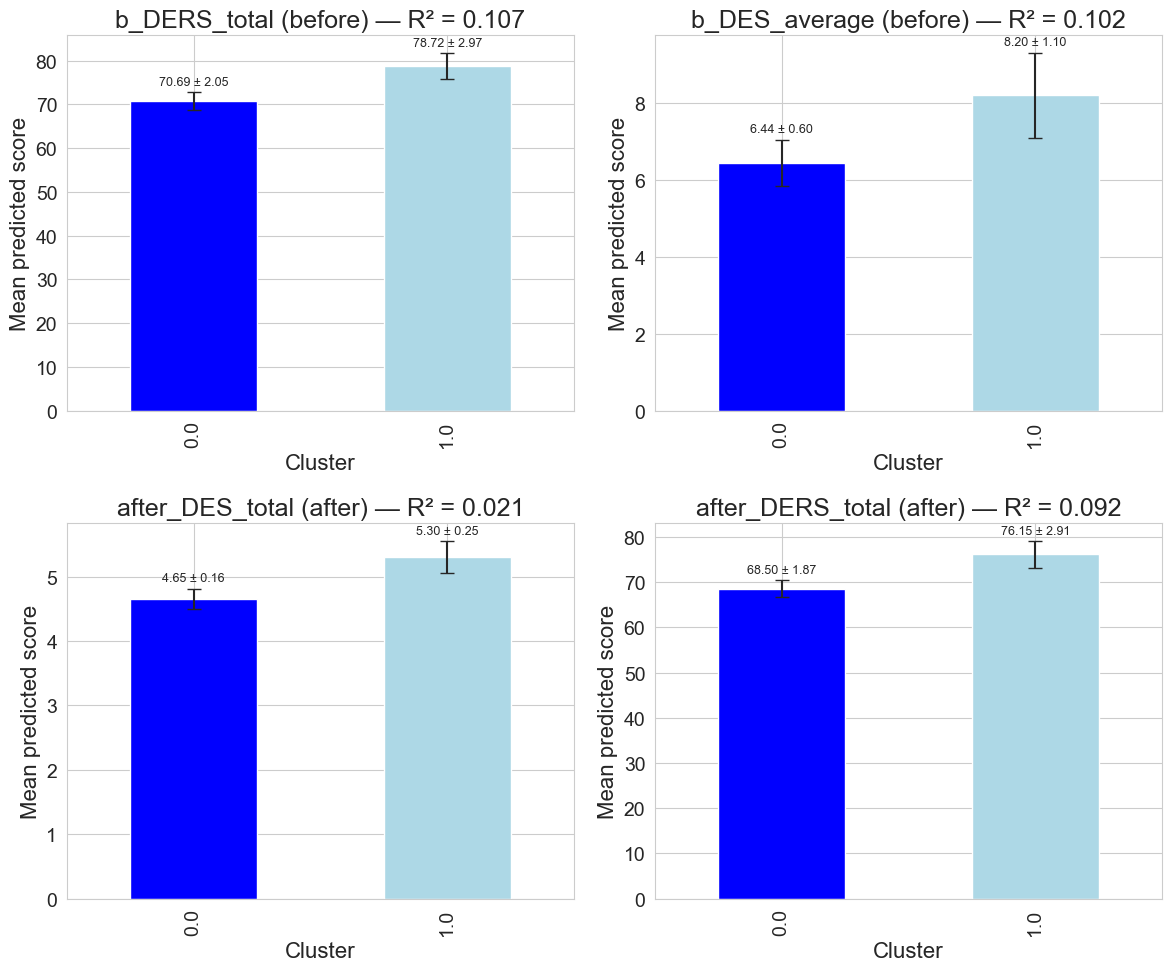

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Load prediction CSV
# -------------------------
csv_path = r"data/only_Q_outputs/combined/subjects_b_predictions_with_r2.csv"
df = pd.read_csv(csv_path)

# -------------------------
# 2. Identify prediction parameter columns
# -------------------------
pred_cols = [c for c in df.columns if c.startswith("pred_")]
param_pairs = {pred: pred.replace("pred_", "R2_") for pred in pred_cols}

# -------------------------
# 3. Create 2×2 subplot layout
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()   # flatten array for easier indexing

# custom colors
colors = {0: "blue", 1: "lightblue", "0": "blue", "1": "lightblue"}

# -------------------------
# 4. Loop through each predicted parameter
# -------------------------
for idx, pred_col in enumerate(pred_cols):

    ax = axes[idx]
    param_name = pred_col.replace("pred_", "")
    r2_col = param_pairs[pred_col]
    r2_value = df[r2_col].iloc[0]

    # Determine timepoint
    if param_name.startswith("b_"):
        timepoint = "before"
    elif param_name.startswith("after_"):
        timepoint = "after"
    else:
        timepoint = "unknown"

    # Compute mean & std per cluster
    stats = df.groupby("cluster")[pred_col].agg(["mean", "std"])

    # pick colors for bars in order of cluster index
    bar_colors = [colors.get(c, "gray") for c in stats.index]

    # -------------------------
    # Plot bar graph into subplot
    # -------------------------
    stats["mean"].plot(kind="bar", ax=ax, color=bar_colors,
                       yerr=stats["std"], capsize=5)

    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean predicted score")
    ax.set_title(f"{param_name} ({timepoint}) — R² = {r2_value:.3f}")

    # Add mean ± std as text
    for i, (cluster, row) in enumerate(stats.iterrows()):
        mean_val = row["mean"]
        std_val = row["std"]
        ax.text(
            i,
            mean_val + std_val + 0.02 * df[pred_col].max(),
            f"{mean_val:.2f} ± {std_val:.2f}",
            ha="center",
            fontsize=9
        )

plt.tight_layout()
plt.show()


### AFTER

In [37]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

# -------------------------
# 1. Load the merged dataset
# -------------------------
data_path = r"data/only_Q_outputs/combined/subjects_pc_after_with_regression.csv"
df = pd.read_csv(data_path)
print(df.columns.tolist())
# -------------------------
# 2. Identify predictor PC1 column
# -------------------------
pc_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13"]

# -------------------------
# 3. Targets
# -------------------------
targets = ["b_DERS_total", "b_DES_average", "after_DES_total", "after_DERS_total"]

# Final prediction dataframe
prediction_df = df[["Subject_Code", "cluster"]].copy()

results = {}

for target in targets:

    # Remove NA rows
    valid_df = df[pc_cols + [target]].dropna()
    X = valid_df[pc_cols]
    y = valid_df[target]

    # -------------------------
    # Use ALL data in cross-validation (no manual split)
    # -------------------------
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X, y)

    # Predictions on all subjects
    X_all = df[pc_cols]
    all_preds = lasso.predict(X_all)

    # Compute R2 on full cross-validated fit
    r2 = lasso.score(X, y)

    # Store
    prediction_df[f"pred_{target}"] = all_preds
    prediction_df[f"R2_{target}"] = r2

    results[target] = {
        "alpha": lasso.alpha_,
        "coef_PC1": float(lasso.coef_[0]),
        "intercept": float(lasso.intercept_),
        "R2": r2
    }

# Save file
output_path = r"data/only_Q_outputs/combined/subjects_after_predictions_with_r2.csv"
prediction_df.to_csv(output_path, index=False)

print("Saved:", output_path)


['Subject_Code', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'b_DERS_total', 'b_DES_average', 'after_DES_total', 'after_DERS_total', 'cluster']
Saved: data/only_Q_outputs/combined/subjects_after_predictions_with_r2.csv


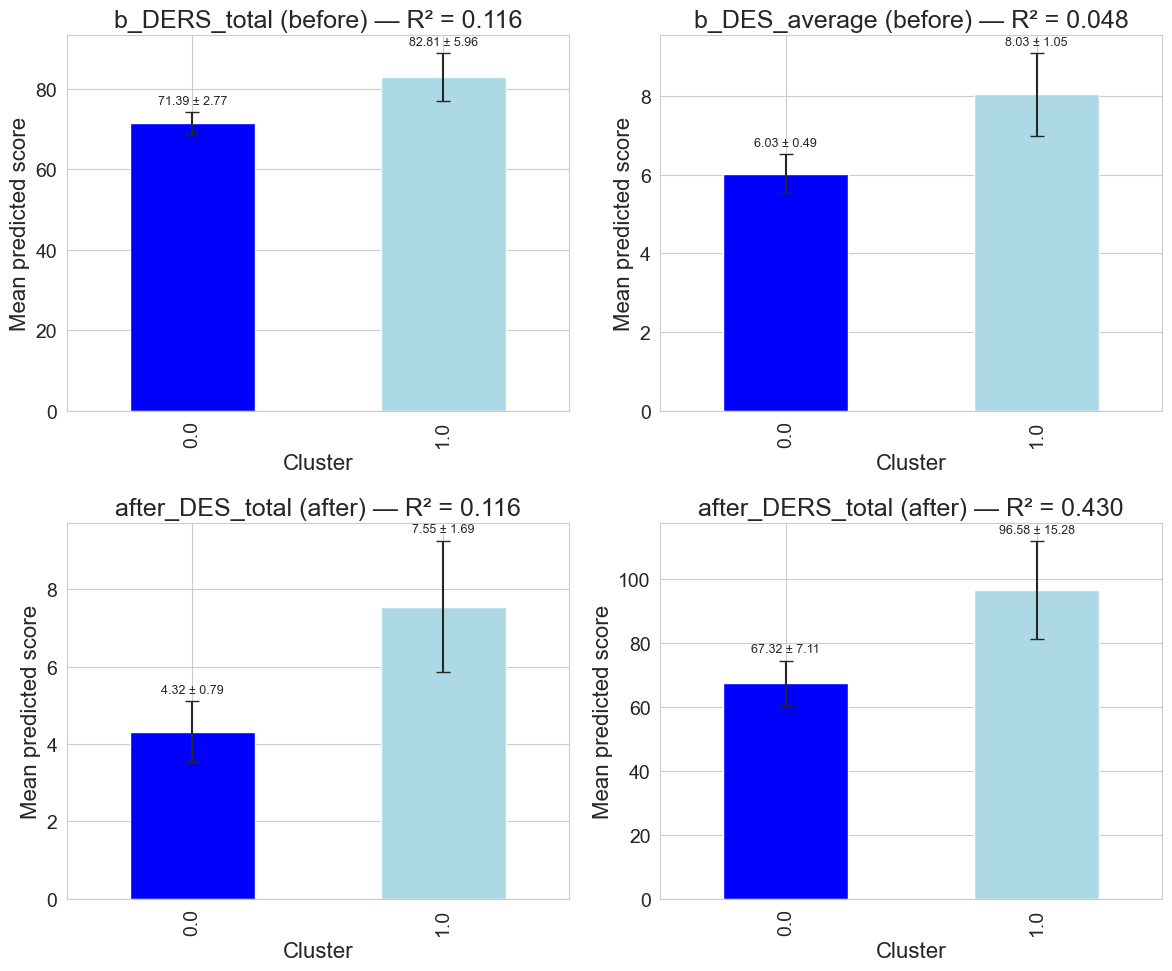

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Load prediction CSV
# -------------------------
csv_path = r"data/only_Q_outputs/combined/subjects_after_predictions_with_r2.csv"
df = pd.read_csv(csv_path)

# -------------------------
# 2. Identify prediction parameter columns
# -------------------------
pred_cols = [c for c in df.columns if c.startswith("pred_")]
param_pairs = {pred: pred.replace("pred_", "R2_") for pred in pred_cols}

# -------------------------
# 3. Create 2×2 subplot layout
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()   # flatten array for easier indexing

# custom colors
colors = {0: "blue", 1: "lightblue", "0": "blue", "1": "lightblue"}

# -------------------------
# 4. Loop through each predicted parameter
# -------------------------
for idx, pred_col in enumerate(pred_cols):

    ax = axes[idx]
    param_name = pred_col.replace("pred_", "")
    r2_col = param_pairs[pred_col]
    r2_value = df[r2_col].iloc[0]

    # Determine timepoint
    if param_name.startswith("b_"):
        timepoint = "before"
    elif param_name.startswith("after_"):
        timepoint = "after"
    else:
        timepoint = "unknown"

    # Compute mean & std per cluster
    stats = df.groupby("cluster")[pred_col].agg(["mean", "std"])

    # pick colors for bars in order of cluster index
    bar_colors = [colors.get(c, "gray") for c in stats.index]

    # -------------------------
    # Plot bar graph into subplot
    # -------------------------
    stats["mean"].plot(kind="bar", ax=ax, color=bar_colors,
                       yerr=stats["std"], capsize=5)

    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean predicted score")
    ax.set_title(f"{param_name} ({timepoint}) — R² = {r2_value:.3f}")

    # Add mean ± std as text
    for i, (cluster, row) in enumerate(stats.iterrows()):
        mean_val = row["mean"]
        std_val = row["std"]
        ax.text(
            i,
            mean_val + std_val + 0.02 * df[pred_col].max(),
            f"{mean_val:.2f} ± {std_val:.2f}",
            ha="center",
            fontsize=9
        )

plt.tight_layout()
plt.show()


## prediction without cross validation

### before

In [39]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# -------------------------
# 1. Load the merged dataset
# -------------------------
data_path = r"data/only_Q_outputs/combined/subjects_pc_after_with_regression.csv"
df = pd.read_csv(data_path)
print(df.columns.tolist())

# -------------------------
# 2. Identify PC columns
# -------------------------
pc_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7",
           "PC8","PC9","PC10","PC11","PC12","PC13"]

# -------------------------
# 3. Targets
# -------------------------
targets = ["b_DERS_total", "b_DES_average", "after_DES_total", "after_DERS_total"]

# Final prediction dataframe
prediction_df = df[["Subject_Code", "cluster"]].copy()

results = {}

# Choose alpha manually (you can adjust)
ALPHA = 0.01

for target in targets:

    # Remove NA rows
    valid_df = df[pc_cols + [target]].dropna()
    X = valid_df[pc_cols]
    y = valid_df[target]

    # -------------------------
    # 4. Lasso WITHOUT cross-validation
    # -------------------------
    lasso = Lasso(alpha=ALPHA, random_state=42)
    lasso.fit(X, y)

    # Predictions for ALL subjects
    X_all = df[pc_cols]
    all_preds = lasso.predict(X_all)

    # Compute R2 on training data
    r2 = lasso.score(X, y)

    # Store predictions
    prediction_df[f"pred_{target}"] = all_preds
    prediction_df[f"R2_{target}"] = r2

    # Store model info
    results[target] = {
        "alpha_used": ALPHA,
        "coefficients": list(lasso.coef_),
        "intercept": float(lasso.intercept_),
        "R2": r2
    }

# -------------------------
# 5. Save file
# -------------------------
output_path = r"data/only_Q_outputs/combined/subjects_b_predictions_with_r2_without_cv.csv"
prediction_df.to_csv(output_path, index=False)
print("Saved:", output_path)

# -------------------------
# 6. Print summary
# -------------------------
for target, info in results.items():
    print("\n==============================")
    print("Target:", target)
    print("==============================")
    print("Alpha used:", info["alpha_used"])
    print("Intercept:", info["intercept"])
    print("R²:", info["R2"])
    print("Coefficients:")
    for pc, coef in zip(pc_cols, info["coefficients"]):
        print(f"  {pc}: {coef:.4f}")


['Subject_Code', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'b_DERS_total', 'b_DES_average', 'after_DES_total', 'after_DERS_total', 'cluster']
Saved: data/only_Q_outputs/combined/subjects_b_predictions_with_r2_without_cv.csv

Target: b_DERS_total
Alpha used: 0.01
Intercept: 70.04627720548962
R²: 0.241869572727623
Coefficients:
  PC1: 2.2377
  PC2: -1.5722
  PC3: -1.5339
  PC4: -0.6743
  PC5: 3.7819
  PC6: -0.4090
  PC7: -0.0154
  PC8: 4.2304
  PC9: -1.0769
  PC10: -3.9409
  PC11: 0.8008
  PC12: 1.2617
  PC13: 2.7784

Target: b_DES_average
Alpha used: 0.01
Intercept: 5.911607130620592
R²: 0.1671344870378183
Coefficients:
  PC1: 0.4677
  PC2: -0.2790
  PC3: -0.5941
  PC4: -0.5231
  PC5: 0.3999
  PC6: -0.1049
  PC7: 0.4898
  PC8: 0.4656
  PC9: 0.0799
  PC10: -1.0025
  PC11: -0.6512
  PC12: 0.8653
  PC13: -1.1266

Target: after_DES_total
Alpha used: 0.01
Intercept: 4.3537607152919175
R²: 0.21425829088526094
Coefficients:
  PC1: 0.5667
  P

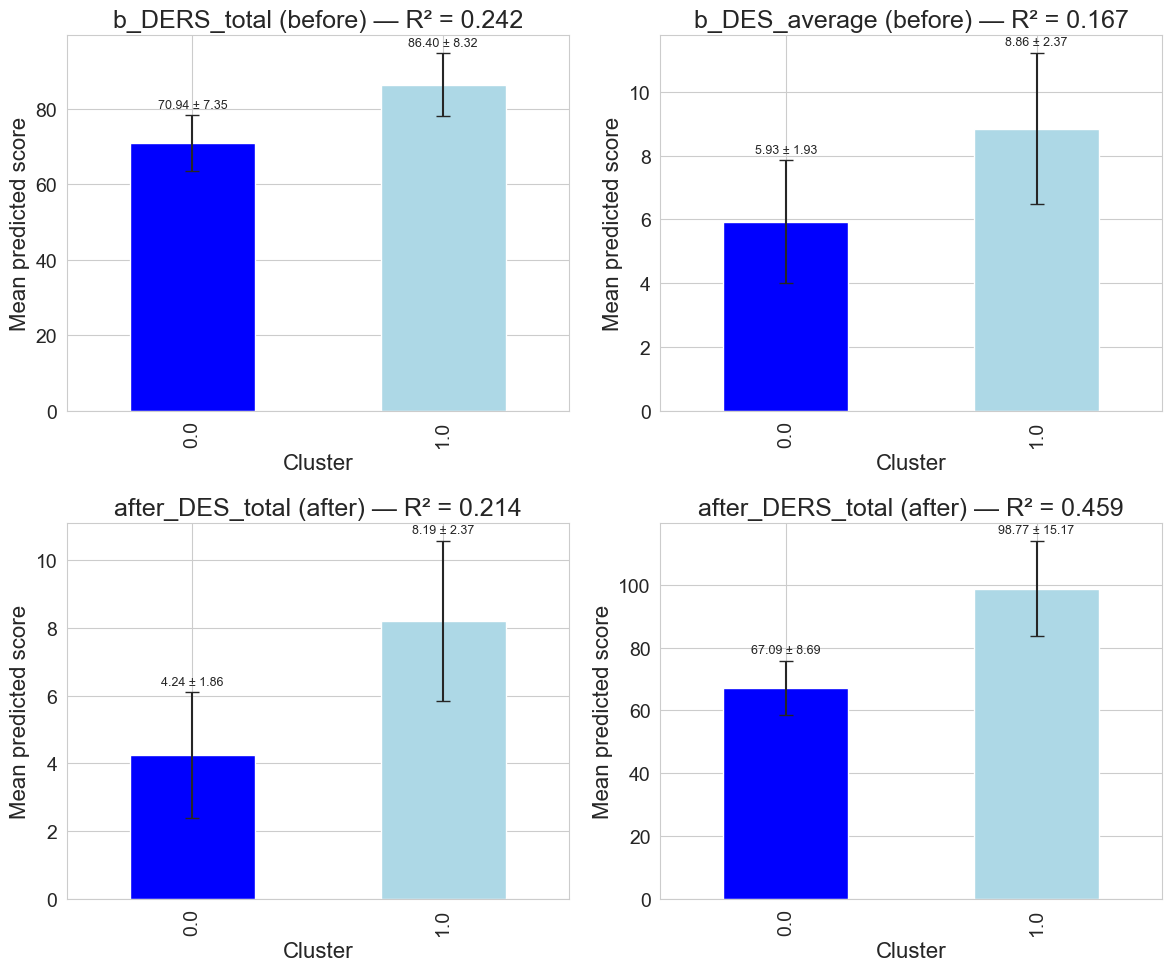

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Load prediction CSV
# -------------------------
csv_path = r"data/only_Q_outputs/combined/subjects_b_predictions_with_r2_without_cv.csv"
df = pd.read_csv(csv_path)

# -------------------------
# 2. Identify prediction parameter columns
# -------------------------
pred_cols = [c for c in df.columns if c.startswith("pred_")]
param_pairs = {pred: pred.replace("pred_", "R2_") for pred in pred_cols}

# -------------------------
# 3. Create 2×2 subplot layout
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()   # flatten array for easier indexing

# custom colors
colors = {0: "blue", 1: "lightblue", "0": "blue", "1": "lightblue"}

# -------------------------
# 4. Loop through each predicted parameter
# -------------------------
for idx, pred_col in enumerate(pred_cols):

    ax = axes[idx]
    param_name = pred_col.replace("pred_", "")
    r2_col = param_pairs[pred_col]
    r2_value = df[r2_col].iloc[0]

    # Determine timepoint
    if param_name.startswith("b_"):
        timepoint = "before"
    elif param_name.startswith("after_"):
        timepoint = "after"
    else:
        timepoint = "unknown"

    # Compute mean & std per cluster
    stats = df.groupby("cluster")[pred_col].agg(["mean", "std"])

    # pick colors for bars in order of cluster index
    bar_colors = [colors.get(c, "gray") for c in stats.index]

    # -------------------------
    # Plot bar graph into subplot
    # -------------------------
    stats["mean"].plot(kind="bar", ax=ax, color=bar_colors,
                       yerr=stats["std"], capsize=5)

    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean predicted score")
    ax.set_title(f"{param_name} ({timepoint}) — R² = {r2_value:.3f}")

    # Add mean ± std as text
    for i, (cluster, row) in enumerate(stats.iterrows()):
        mean_val = row["mean"]
        std_val = row["std"]
        ax.text(
            i,
            mean_val + std_val + 0.02 * df[pred_col].max(),
            f"{mean_val:.2f} ± {std_val:.2f}",
            ha="center",
            fontsize=9
        )

plt.tight_layout()
plt.show()


### after

In [41]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# -------------------------
# 1. Load the merged dataset
# -------------------------
data_path = r"data/only_Q_outputs/combined/subjects_pc_after_with_regression.csv"
df = pd.read_csv(data_path)
print(df.columns.tolist())

# -------------------------
# 2. Identify PC columns
# -------------------------
pc_cols = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7",
           "PC8","PC9","PC10","PC11","PC12","PC13"]

# -------------------------
# 3. Targets
# -------------------------
targets = ["b_DERS_total", "b_DES_average", "after_DES_total", "after_DERS_total"]

# Final prediction dataframe
prediction_df = df[["Subject_Code", "cluster"]].copy()

results = {}

# Choose alpha manually (you can adjust)
ALPHA = 0.01

for target in targets:

    # Remove NA rows
    valid_df = df[pc_cols + [target]].dropna()
    X = valid_df[pc_cols]
    y = valid_df[target]

    # -------------------------
    # 4. Lasso WITHOUT cross-validation
    # -------------------------
    lasso = Lasso(alpha=ALPHA, random_state=42)
    lasso.fit(X, y)

    # Predictions for ALL subjects
    X_all = df[pc_cols]
    all_preds = lasso.predict(X_all)

    # Compute R2 on training data
    r2 = lasso.score(X, y)

    # Store predictions
    prediction_df[f"pred_{target}"] = all_preds
    prediction_df[f"R2_{target}"] = r2

    # Store model info
    results[target] = {
        "alpha_used": ALPHA,
        "coefficients": list(lasso.coef_),
        "intercept": float(lasso.intercept_),
        "R2": r2
    }

# -------------------------
# 5. Save file
# -------------------------
output_path = r"data/only_Q_outputs/combined/subjects_after_predictions_with_r2_without_cv.csv"
prediction_df.to_csv(output_path, index=False)
print("Saved:", output_path)

# -------------------------
# 6. Print summary
# -------------------------
for target, info in results.items():
    print("\n==============================")
    print("Target:", target)
    print("==============================")
    print("Alpha used:", info["alpha_used"])
    print("Intercept:", info["intercept"])
    print("R²:", info["R2"])
    print("Coefficients:")
    for pc, coef in zip(pc_cols, info["coefficients"]):
        print(f"  {pc}: {coef:.4f}")


['Subject_Code', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'b_DERS_total', 'b_DES_average', 'after_DES_total', 'after_DERS_total', 'cluster']
Saved: data/only_Q_outputs/combined/subjects_after_predictions_with_r2_without_cv.csv

Target: b_DERS_total
Alpha used: 0.01
Intercept: 70.04627720548962
R²: 0.241869572727623
Coefficients:
  PC1: 2.2377
  PC2: -1.5722
  PC3: -1.5339
  PC4: -0.6743
  PC5: 3.7819
  PC6: -0.4090
  PC7: -0.0154
  PC8: 4.2304
  PC9: -1.0769
  PC10: -3.9409
  PC11: 0.8008
  PC12: 1.2617
  PC13: 2.7784

Target: b_DES_average
Alpha used: 0.01
Intercept: 5.911607130620592
R²: 0.1671344870378183
Coefficients:
  PC1: 0.4677
  PC2: -0.2790
  PC3: -0.5941
  PC4: -0.5231
  PC5: 0.3999
  PC6: -0.1049
  PC7: 0.4898
  PC8: 0.4656
  PC9: 0.0799
  PC10: -1.0025
  PC11: -0.6512
  PC12: 0.8653
  PC13: -1.1266

Target: after_DES_total
Alpha used: 0.01
Intercept: 4.3537607152919175
R²: 0.21425829088526094
Coefficients:
  PC1: 0.5667

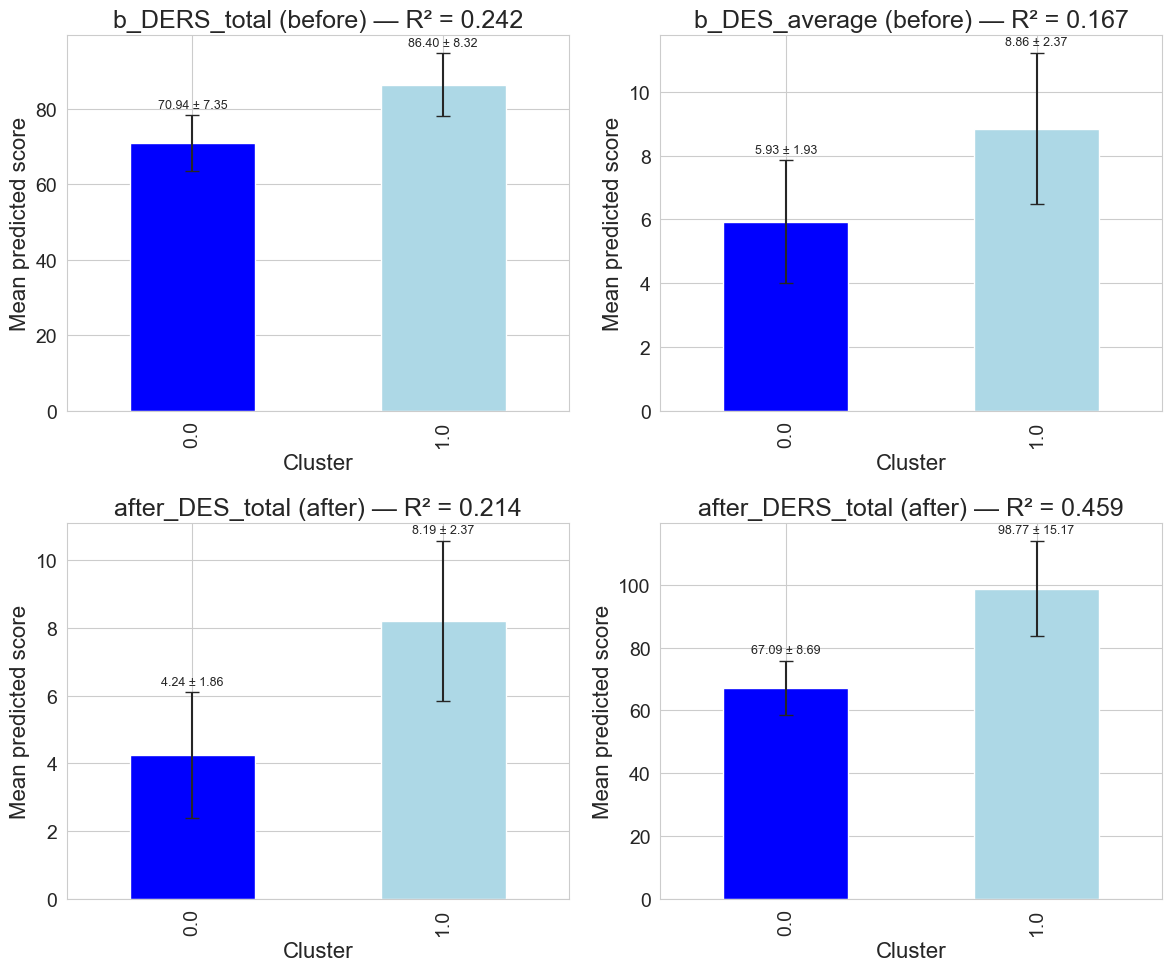

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Load prediction CSV
# -------------------------
csv_path = r"data/only_Q_outputs/combined/subjects_after_predictions_with_r2_without_cv.csv"
df = pd.read_csv(csv_path)

# -------------------------
# 2. Identify prediction parameter columns
# -------------------------
pred_cols = [c for c in df.columns if c.startswith("pred_")]
param_pairs = {pred: pred.replace("pred_", "R2_") for pred in pred_cols}

# -------------------------
# 3. Create 2×2 subplot layout
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()   # flatten array for easier indexing

# custom colors
colors = {0: "blue", 1: "lightblue", "0": "blue", "1": "lightblue"}

# -------------------------
# 4. Loop through each predicted parameter
# -------------------------
for idx, pred_col in enumerate(pred_cols):

    ax = axes[idx]
    param_name = pred_col.replace("pred_", "")
    r2_col = param_pairs[pred_col]
    r2_value = df[r2_col].iloc[0]

    # Determine timepoint
    if param_name.startswith("b_"):
        timepoint = "before"
    elif param_name.startswith("after_"):
        timepoint = "after"
    else:
        timepoint = "unknown"

    # Compute mean & std per cluster
    stats = df.groupby("cluster")[pred_col].agg(["mean", "std"])

    # pick colors for bars in order of cluster index
    bar_colors = [colors.get(c, "gray") for c in stats.index]

    # -------------------------
    # Plot bar graph into subplot
    # -------------------------
    stats["mean"].plot(kind="bar", ax=ax, color=bar_colors,
                       yerr=stats["std"], capsize=5)

    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean predicted score")
    ax.set_title(f"{param_name} ({timepoint}) — R² = {r2_value:.3f}")

    # Add mean ± std as text
    for i, (cluster, row) in enumerate(stats.iterrows()):
        mean_val = row["mean"]
        std_val = row["std"]
        ax.text(
            i,
            mean_val + std_val + 0.02 * df[pred_col].max(),
            f"{mean_val:.2f} ± {std_val:.2f}",
            ha="center",
            fontsize=9
        )

plt.tight_layout()
plt.show()
